
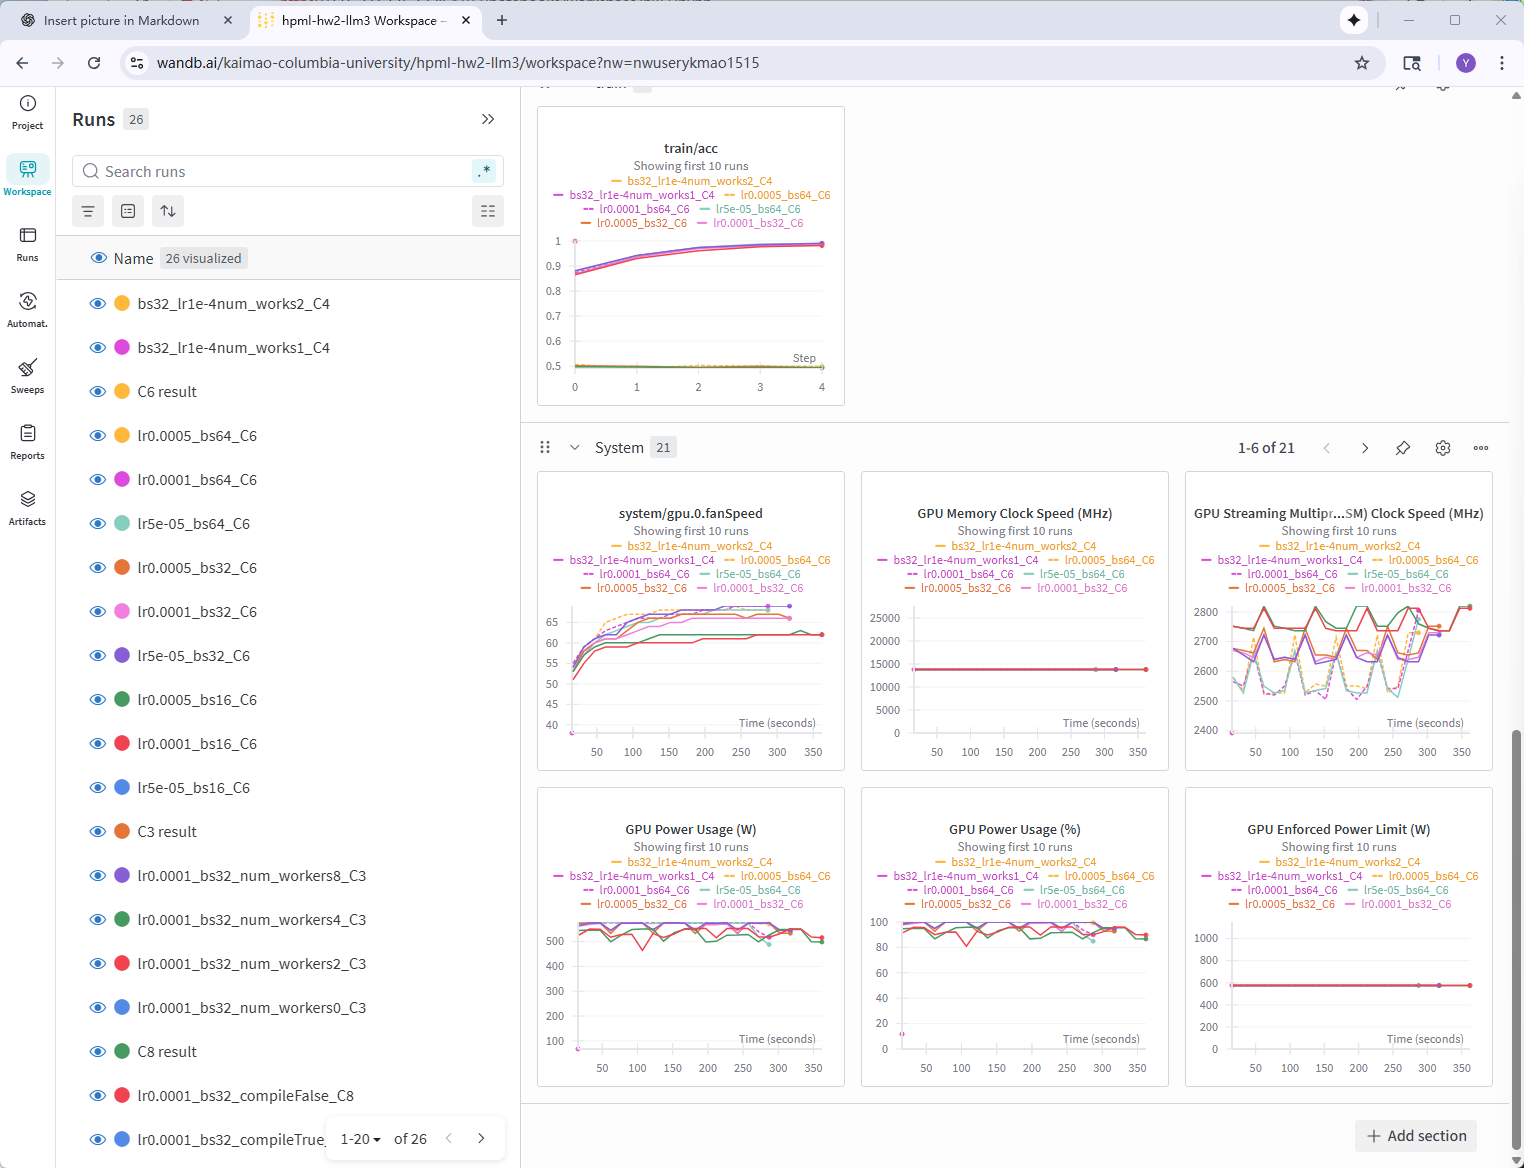 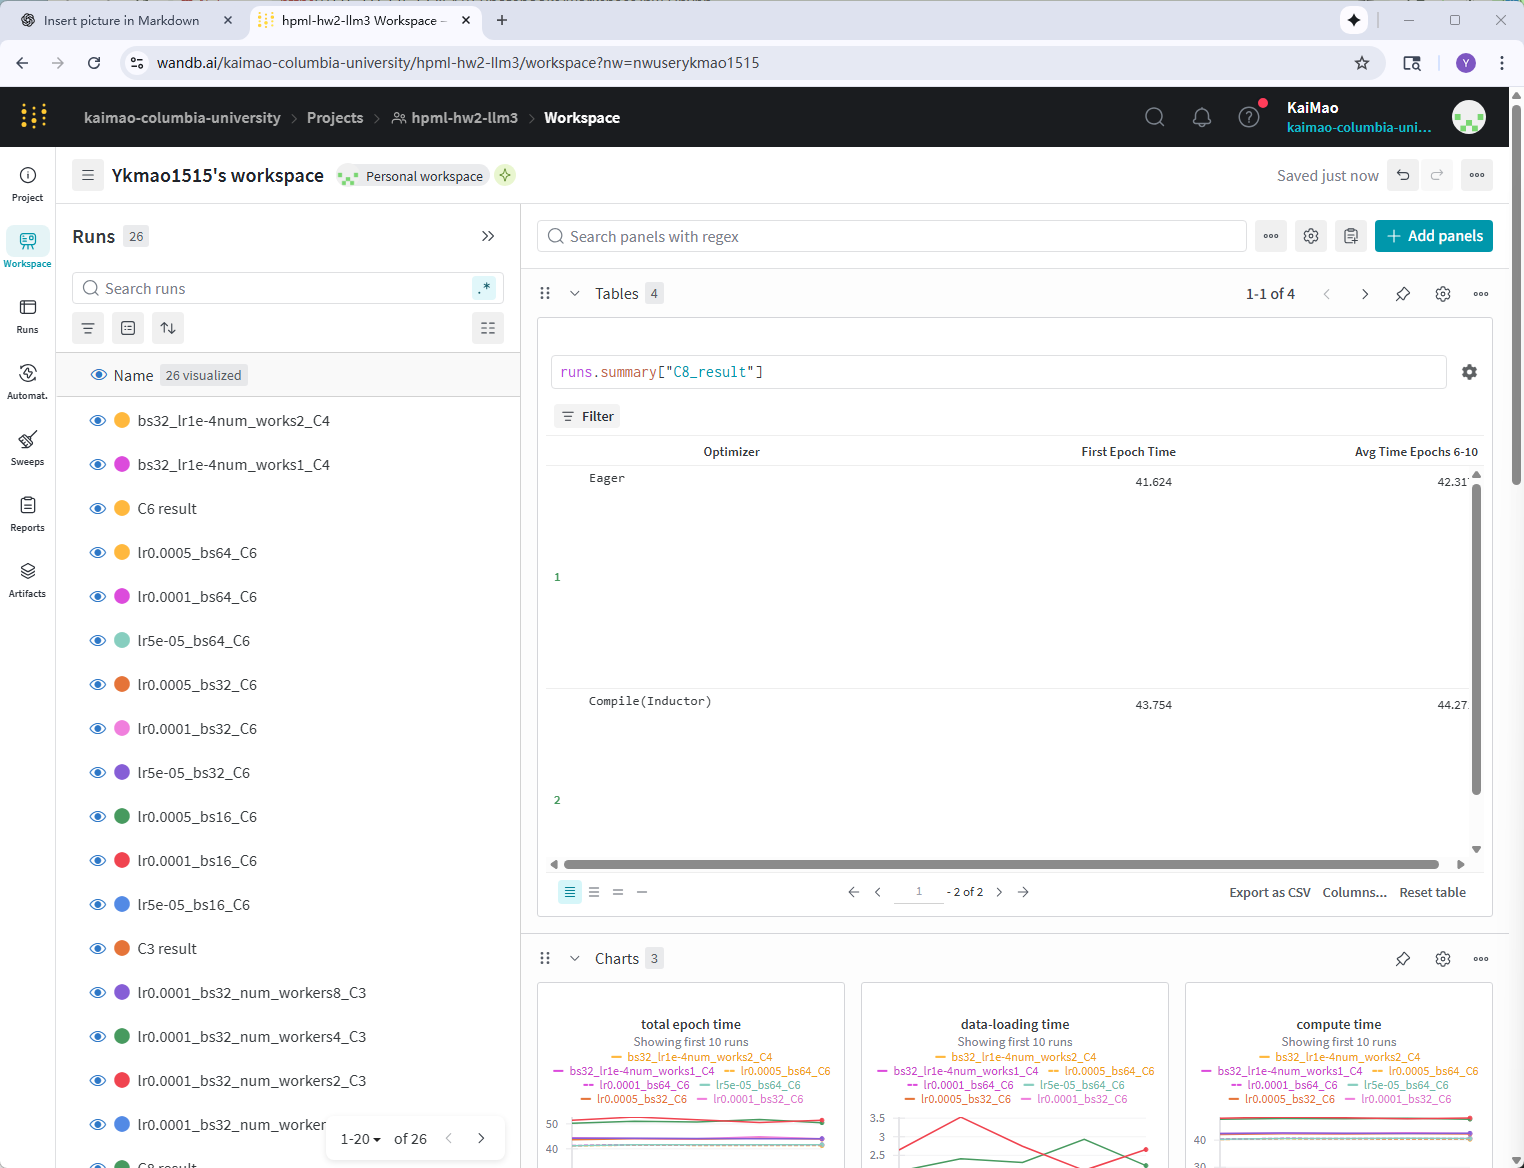 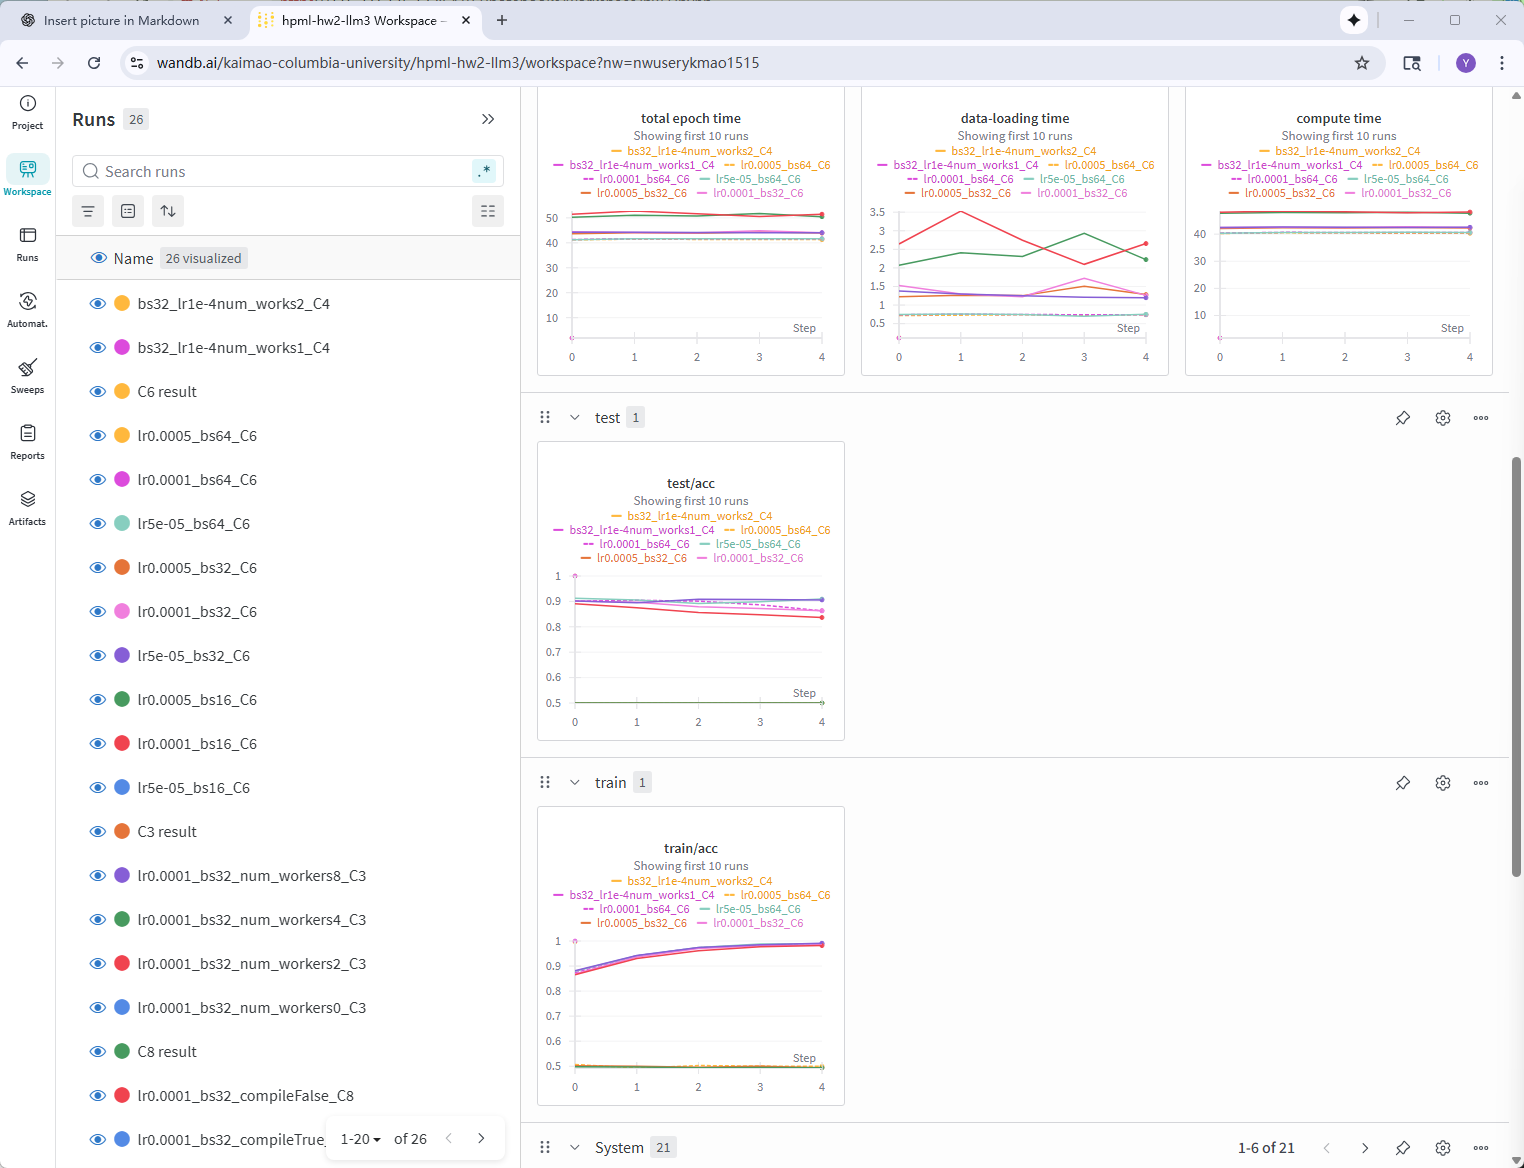

In [1]:
!python3 -m venv venv
!venv/bin/python -m pip install ipykernel
!venv/bin/python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"
%pip install datasets wandb transformers matplotlib torch-tb-profiler pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 236.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 698.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.0/841.0 kB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.9/443.9 kB 828.3 kB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.4/391.4 kB 9.6

In [2]:
import torch
import torch.optim as optim
import numpy as np
import wandb
from tqdm import tqdm
from torch.optim import AdamW
import pandas as pd
torch.cuda.manual_seed_all(423)

/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
project_name = "hpml-hw2-llm3"

In [4]:
from datasets import load_dataset

dataset = load_dataset("imdb")
print(dataset)

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [5]:
from transformers import DistilBertForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding
import time
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## C1

In [5]:
import wandb

wandb.init(project=project_name, name=f"bs32_lr1e-4", group = "Warm Up Experiment")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": 256,
    "batch_size": 32,
    "lr": 1e-4,
    "optimizer": "AdamW",
    "num_workers": 2,
    "epochs": 5,
    "compile_mode": False
})

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ykmao1515 (kaimao-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:


config = wandb.config

model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=config.lr)

train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(config.epochs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  for batch in tqdm(train_loader):
      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
           "train/acc": avg_accuracy,
           "test/acc": accuracy})
  print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variabl

Epoch 1/5, Loss: 0.3088, Train Accuracy: 0.8696, Test Accuracy: 0.8678


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:43<00:00, 17.84it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 2/5, Loss: 0.1716, Train Accuracy: 0.9369, Test Accuracy: 0.8880


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:44<00:00, 17.50it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 3/5, Loss: 0.0863, Train Accuracy: 0.9706, Test Accuracy: 0.8694


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:43<00:00, 17.80it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 4/5, Loss: 0.0522, Train Accuracy: 0.9814, Test Accuracy: 0.8735


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:44<00:00, 17.72it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 5/5, Loss: 0.0415, Train Accuracy: 0.9856, Test Accuracy: 0.8624


In [7]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test/acc,▂█▃▄▁
train/acc,▁▅▇██
test/acc,0.86236
train/acc,0.98564


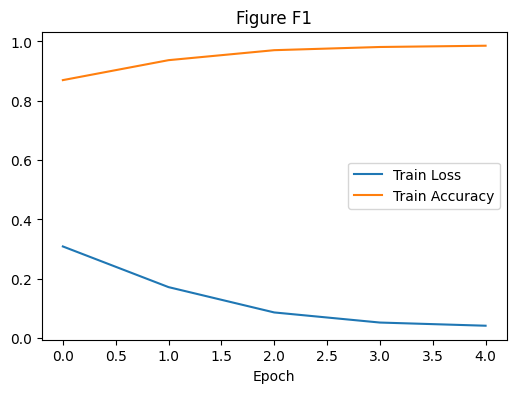

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
# plt.ylabel('Value')
plt.title('Figure F1')
plt.legend()
plt.show()

In [9]:
print(train_loss, train_accuracy, test_accuracy)

[0.30880285602282076, 0.1716375277470559, 0.08625857711202749, 0.052180667354515695, 0.04147789674672468] [0.86964, 0.93692, 0.9706, 0.98136, 0.98564] [0.8678, 0.88804, 0.86936, 0.87352, 0.86236]


# Table T1

| Epoch | Train Loss | Train Acc | Test Acc |
|-------|------------|-----------|----------|
|1|0.30880|0.86964|0.8678|
|2|0.17163|0.93692|0.8880|
|3|0.08625|0.9706|0.86936|
|4|0.05218|0.98136|0.87352|
|5|0.04147|0.98564|0.86236|

# Figure F1
![Figure F1.png](<attachment:Figure F1.png>)
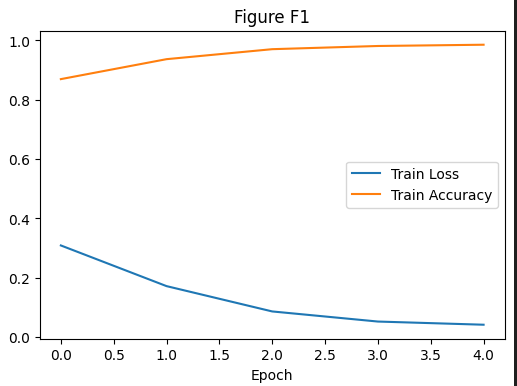

# C2

In [1]:
wandb.init(project=project_name, name=f"bs32_lr1e-4", group = "Baseline Timing")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": 256,
    "batch_size": 32,
    "lr": 1e-4,
    "optimizer": "AdamW",
    "num_workers": 2,
    "epochs": 5,
    "compile_mode": False
})

NameError: name 'wandb' is not defined

In [ ]:
import time

config = wandb.config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=config.lr)

train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)

train_loss = []
train_accuracy = []
test_accuracy = []
data_loading_time_arr = []
compute_time_arr = []
epoch_time_arr = []

for epoch in range(config.epochs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  data_loading_time = 0
  training_compute_time = 0
  total_epoch_time = 0
  start_data_loading = time.time()
  start_epoch_time = time.time()
  for batch in train_loader:
      torch.cuda.synchronize()
      end = time.time()
      data_loading_time +=  end - start_data_loading

      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      start_compute = time.time()
      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      torch.cuda.synchronize()
      end = time.time()
      training_compute_time += end - start_compute

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

      start_data_loading = time.time()

  end = time.time()
  total_epoch_time = end - start_epoch_time

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
            "train/acc": avg_accuracy,
            "test/acc": accuracy,
             "data-loading time": data_loading_time,
             "compute time": training_compute_time,
             "total epoch time": total_epoch_time})

  data_loading_time_arr.append(data_loading_time)
  compute_time_arr.append(training_compute_time)
  epoch_time_arr.append(total_epoch_time)
  print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
          compute time: {training_compute_time} total epoch time: {total_epoch_time}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

Epoch 1/5, Loss: 0.3080, Train Accuracy: 0.8673, Test Accuracy: 0.9033, data_loading time: 1.1362109184265137           compute time: 41.57454490661621 total epoch time: 43.28198599815369


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1663, Train Accuracy: 0.9389, Test Accuracy: 0.8952, data_loading time: 1.230752944946289           compute time: 42.04773426055908 total epoch time: 43.87720322608948


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0868, Train Accuracy: 0.9706, Test Accuracy: 0.8845, data_loading time: 1.2963290214538574           compute time: 42.078760862350464 total epoch time: 43.954166650772095


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0532, Train Accuracy: 0.9836, Test Accuracy: 0.8785, data_loading time: 1.4094874858856201           compute time: 42.1745662689209 total epoch time: 44.2338387966156


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0406, Train Accuracy: 0.9867, Test Accuracy: 0.8608, data_loading time: 1.4818291664123535           compute time: 42.24960660934448 total epoch time: 44.39625382423401


In [ ]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▆▆▇█
data-loading time,▁▃▄▇█
test/acc,█▇▅▄▁
total epoch time,▁▅▅▇█
train/acc,▁▅▇██
compute time,42.24961
data-loading time,1.48183
test/acc,0.8608
total epoch time,44.39625
train/acc,0.98672


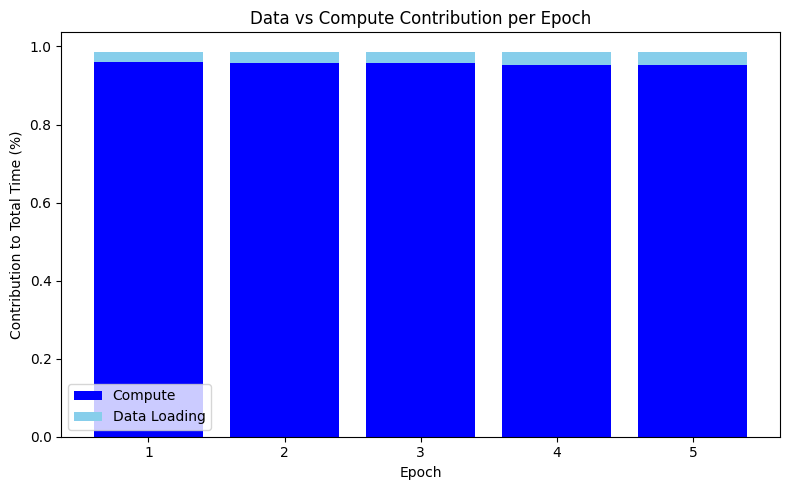

In [ ]:
plt.figure(figsize=(8, 5))

epochs = [1, 2, 3, 4, 5]
# Stack bars
plt.bar(epochs, np.array(compute_time_arr)/np.array(epoch_time_arr), label='Compute', color='blue')
plt.bar(epochs, np.array(data_loading_time_arr)/np.array(epoch_time_arr), bottom=np.array(compute_time_arr)/np.array(epoch_time_arr), label='Data Loading', color='skyblue')

# 🧾 Annotate total time on top of each bar
# for i in range(len(epochs)):
#     plt.text(epochs[i], epoch_time_arr[i] + 0.3, f"{epoch_time_arr[i]:.1f}s",
#              ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Epoch')
plt.ylabel('Contribution to Total Time (%)')
plt.title('Data vs Compute Contribution per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(data_loading_time_arr, compute_time_arr, epoch_time_arr)

[1.1362109184265137, 1.230752944946289, 1.2963290214538574, 1.4094874858856201, 1.4818291664123535] [41.57454490661621, 42.04773426055908, 42.078760862350464, 42.1745662689209, 42.24960660934448] [43.28198599815369, 43.87720322608948, 43.954166650772095, 44.2338387966156, 44.39625382423401]


# Table T2

| Epoch | Data Time(s) | Compute Time(s) | Total(s) | Device |
|-------|------------|-----------|----------|----------|
|1|1.13621|41.57454|43.28198| GPU|
|2|1.23075|42.04773|43.87720| GPU|
|3|1.29632|42.07876|43.95416| GPU|
|4|1.40948|42.17456|44.23383| GPU|
|5|1.48182|42.24960|44.39625| GPU|
# Figure F2
![Figure F2.png](<attachment:Figure F2.png>)
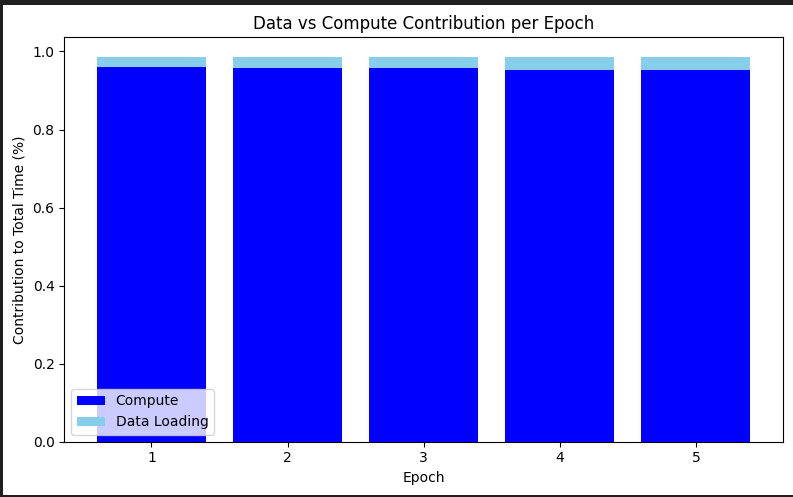

# C3

In [5]:
avg_epoch_time_arr = []
avg_data_time_arr = []

def train():
  with wandb.init(
      group="DataLoader Performance",
      config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "optimizer": "AdamW", 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
      config = wandb.config
      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_num_workers{config.num_workers}_C3"
      
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time() 
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
          
      avg_epoch_time_arr.append(sum(epoch_time_arr)/len(epoch_time_arr))
      avg_data_time_arr.append(sum(data_loading_time_arr)/len(data_loading_time_arr))
      

In [6]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'num_workers': {'values': [0, 2, 4, 8]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train, count=4)

wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 0vkzkara
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/0vkzkara


wandb: Agent Starting Run: qdnsf7w2 with config:
wandb: 	num_workers: 0
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ykmao1515 (kaimao-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(0) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3068, Train Accuracy: 0.8698, Test Accuracy: 0.8830, data_loading time: 3.207254648208618                 compute time: 42.14731478691101 total epoch time: 45.59546518325806
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1683, Train Accuracy: 0.9381, Test Accuracy: 0.8951, data_loading time: 3.2103919982910156                 compute time: 42.06193470954895 total epoch time: 45.4927191734314
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0812, Train Accuracy: 0.9729, Test Accuracy: 0.8687, data_loading time: 3.2201642990112305                 compute time: 42.12448191642761 total epoch time: 45.56506967544556
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0552, Train Accuracy: 0.9818, Test Accuracy: 0.8828, data_loading time: 3.22

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0459, Train Accuracy: 0.9848, Test Accuracy: 0.8716, data_loading time: 3.2410035133361816                 compute time: 42.09473752975464 total epoch time: 45.55516505241394
-------------------------------------------------------------------------------


compute time,█▁▆▅▄
data-loading time,▁▂▄▅█
test/acc,▅█▁▅▂
total epoch time,█▁▆▅▅
train/acc,▁▅▇██
compute time,42.09474
data-loading time,3.241
test/acc,0.87164
total epoch time,45.55517
train/acc,0.98476


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l1vblfsg with config:
wandb: 	num_workers: 2
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3109, Train Accuracy: 0.8689, Test Accuracy: 0.8999, data_loading time: 1.2844583988189697                 compute time: 42.11287546157837 total epoch time: 43.742393016815186
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1702, Train Accuracy: 0.9376, Test Accuracy: 0.8899, data_loading time: 1.1762325763702393                 compute time: 42.3264639377594 total epoch time: 43.83210825920105
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0917, Train Accuracy: 0.9681, Test Accuracy: 0.8803, data_loading time: 1.204374074935913                 compute time: 42.371110916137695 total epoch time: 43.91217541694641
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0529, Train Accuracy: 0.9822, Test Accuracy: 0.8798, data_loading time: 1.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0373, Train Accuracy: 0.9870, Test Accuracy: 0.8713, data_loading time: 1.2159900665283203                 compute time: 42.38497710227966 total epoch time: 43.93879246711731
-------------------------------------------------------------------------------


compute time,▁▆▇██
data-loading time,█▂▃▁▄
test/acc,█▆▃▃▁
total epoch time,▁▄▇▆█
train/acc,▁▅▇██
compute time,42.38498
data-loading time,1.21599
test/acc,0.87132
total epoch time,43.93879
train/acc,0.98696


wandb: Agent Starting Run: m2kjq5pq with config:
wandb: 	num_workers: 4
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(4) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3071, Train Accuracy: 0.8691, Test Accuracy: 0.8984, data_loading time: 1.2442965507507324                 compute time: 42.13042902946472 total epoch time: 43.72322225570679
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1745, Train Accuracy: 0.9359, Test Accuracy: 0.8892, data_loading time: 1.3141040802001953                 compute time: 42.362959146499634 total epoch time: 44.01722812652588
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0858, Train Accuracy: 0.9700, Test Accuracy: 0.8687, data_loading time: 1.32576584815979                 compute time: 42.40106701850891 total epoch time: 44.07692313194275
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0559, Train Accuracy: 0.9815, Test Accuracy: 0.8740, data_loading time: 1.2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0428, Train Accuracy: 0.9855, Test Accuracy: 0.8688, data_loading time: 1.606079339981079                 compute time: 42.548943519592285 total epoch time: 44.54756450653076
-------------------------------------------------------------------------------


compute time,▁▅▆▅█
data-loading time,▁▂▃▁█
test/acc,█▆▁▂▁
total epoch time,▁▃▄▃█
train/acc,▁▅▇██
compute time,42.54894
data-loading time,1.60608
test/acc,0.86876
total epoch time,44.54756
train/acc,0.98552


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gdnlm5y5 with config:
wandb: 	num_workers: 8
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(8) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3075, Train Accuracy: 0.8675, Test Accuracy: 0.8893, data_loading time: 1.3507966995239258                 compute time: 42.09671449661255 total epoch time: 43.81476807594299
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1637, Train Accuracy: 0.9393, Test Accuracy: 0.8778, data_loading time: 1.3857502937316895                 compute time: 42.364134788513184 total epoch time: 44.09523630142212
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0902, Train Accuracy: 0.9688, Test Accuracy: 0.8727, data_loading time: 1.3869707584381104                 compute time: 42.3030309677124 total epoch time: 44.046412229537964
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0525, Train Accuracy: 0.9830, Test Accuracy: 0.8776, data_loading time: 1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0442, Train Accuracy: 0.9851, Test Accuracy: 0.8731, data_loading time: 1.389526605606079                 compute time: 42.33134984970093 total epoch time: 44.03655123710632
-------------------------------------------------------------------------------


compute time,▁█▆▇▇
data-loading time,▁▇█▃█
test/acc,█▃▁▃▁
total epoch time,▁█▇▇▇
train/acc,▁▅▇██
compute time,42.33135
data-loading time,1.38953
test/acc,0.87312
total epoch time,44.03655
train/acc,0.98508


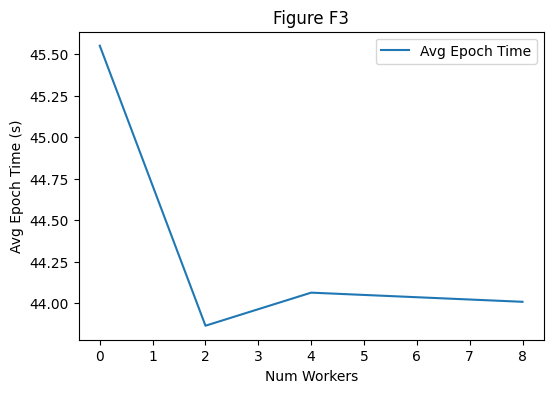

In [9]:
plt.figure(figsize=(6, 4))

num_workers = [0, 2, 4, 8]
plt.plot(num_workers, avg_epoch_time_arr, label='Avg Epoch Time')
plt.xlabel('Num Workers')
plt.ylabel('Avg Epoch Time (s)')
plt.title('Figure F3')
plt.legend()
plt.show()

In [10]:
print(avg_epoch_time_arr, avg_data_time_arr)

[45.55211009979248, 43.86295328140259, 44.062462377548215, 44.007269287109374] [3.220819854736328, 1.2093932151794433, 1.3516160488128661, 1.3752715110778808]


# Table T3
![Table T3.png](<attachment:Table T3.png>)
# Figure F3
![Figure F3.png](<attachment:Figure F3.png>)

Num_workers = 2 is optimal. Num_workers can load data in parallelly with multiprocess. But if num_workers are too large, the overhead such as context swith will regrade performance.
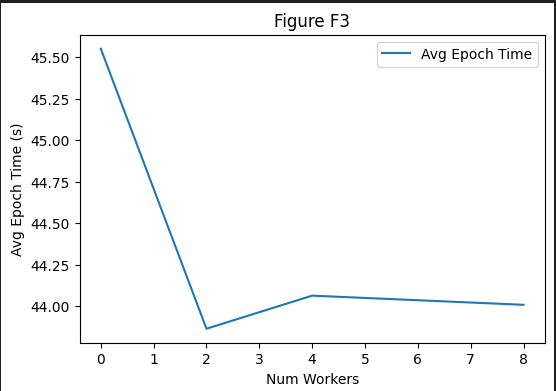
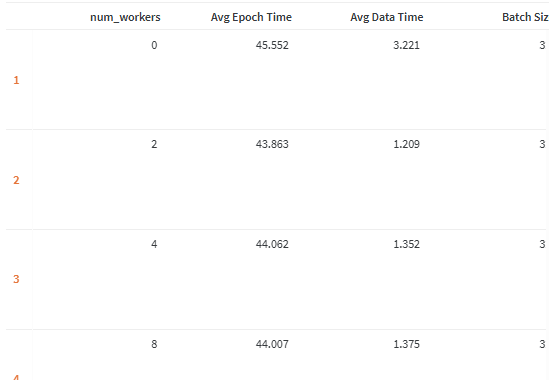

In [11]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [12]:

wandb.init(project=project_name, name=f"C3 result", group = "DataLoader Performance")

records = []
for i in range(4):
    records.append({
        "num_workers": num_workers[i],
        "Avg Epoch Time": avg_epoch_time_arr[i],
        "Avg Data Time": avg_data_time_arr[i],
        "Batch Size": 32
    })

print(records)
df = pd.DataFrame(records)
wandb.log({"C3_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[{'num_workers': 0, 'Avg Epoch Time': 45.55211009979248, 'Avg Data Time': 3.220819854736328, 'Batch Size': 32}, {'num_workers': 2, 'Avg Epoch Time': 43.86295328140259, 'Avg Data Time': 1.2093932151794433, 'Batch Size': 32}, {'num_workers': 4, 'Avg Epoch Time': 44.062462377548215, 'Avg Data Time': 1.3516160488128661, 'Batch Size': 32}, {'num_workers': 8, 'Avg Epoch Time': 44.007269287109374, 'Avg Data Time': 1.3752715110778808, 'Batch Size': 32}]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


# C4

In [6]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [8]:
import torch.profiler as profiler

for num_workers in [1, 2]:
    wandb.init(project=project_name, name=f"bs32_lr1e-4num_works{num_workers}_C4", group = "PyTorch Profiler")

    wandb.config.update({
        "model_name": "distilbert-base-uncased",
        "max_len": 256,
        "batch_size": 32,
        "lr": 1e-4,
        "optimizer": "AdamW",
        "num_workers": num_workers,
        "epochs": 1,
        "compile_mode": False
    })
    config = wandb.config
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "distilbert-base-uncased"
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=config.lr)
    
    train_loader = DataLoader(tokenized["train"].select(range(1000)), batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
    test_loader = DataLoader(tokenized["test"].select(range(1000)), batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
    print(f"config num:{config.num_workers}")
    
    
    with profiler.profile(
        activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA],
        on_trace_ready=torch.profiler.tensorboard_trace_handler(f"./profiler_logs_num_wokers{num_workers}"),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
          train_loss = []
          train_accuracy = []
          test_accuracy = []
          data_loading_time_arr = []
          compute_time_arr = []
          epoch_time_arr = []
        
          for epoch in range(config.epochs):
            model.train()
            total_loss = 0
            total_correct = 0
            total_samples = 0
            data_loading_time = 0
            training_compute_time = 0
            total_epoch_time = 0
            start_data_loading = time.time()
            start_epoch_time = time.time()
            for batch in train_loader:
                with profiler.record_function("data_loading"):
                    inputs = {
                        "input_ids": batch["input_ids"].to(device),
                        "attention_mask": batch["attention_mask"].to(device),
                        "labels": batch["labels"].to(device),
                    }
                torch.cuda.synchronize()
                end = time.time()
                data_loading_time +=  end - start_data_loading
    
                start_compute = time.time()
                with profiler.record_function("forward"):
                    optimizer.zero_grad()
                    outputs = model(**inputs)
                    
                with profiler.record_function("backward"):
                    loss = outputs.loss
                    loss.backward()

                with profiler.record_function("optimizer"):
                    optimizer.step()
        
                torch.cuda.synchronize()
                end = time.time()
                training_compute_time += end - start_compute
        
                logits = outputs.logits
                preds = torch.argmax(logits, dim = 1)
                labels = batch["labels"].to(device)
                correct = (preds == labels).sum().item()
                total_correct += correct
                total_samples += len(labels)
                total_loss += loss.item()
        
                start_data_loading = time.time()
        
            end = time.time()
            total_epoch_time = end - start_epoch_time
        
            avg_loss = total_loss / len(train_loader)
            avg_accuracy = total_correct / total_samples
            train_loss.append(avg_loss)
            train_accuracy.append(avg_accuracy)
        
            model.eval()
            correct = 0
            total = 0
        
            with torch.no_grad():
                for batch in test_loader:
                    inputs = {
                        "input_ids": batch["input_ids"].to(device),
                        "attention_mask": batch["attention_mask"].to(device),
                    }
                    labels = batch["labels"].to(device)
        
                    logits = model(**inputs).logits
                    preds = torch.argmax(logits, dim=1)
        
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
        
            accuracy = correct / total
            test_accuracy.append(accuracy)
        
            wandb.log({"train/loss": train_loss,
                      "train/acc": avg_accuracy,
                      "test/acc": accuracy,
                      "data-loading time": data_loading_time,
                      "compute time": training_compute_time,
                      "total epoch time": total_epoch_time})
        
            data_loading_time_arr.append(data_loading_time)
            compute_time_arr.append(training_compute_time)
            epoch_time_arr.append(total_epoch_time)
            print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                    compute time: {training_compute_time} total epoch time: {total_epoch_time}")
            print(f"-------------------------------------------------------------------------------")
              

            prof.step()

    # print(prof.is_active(), prof.profiler)
    torch.cuda.synchronize()
    with open(f"profile_C4_num_workers_{num_workers}_result.txt", "w") as f:
        print(f"\n===== CPU Profiling num_workers {num_workers}=====",file=f)
        print(prof.key_averages().table(
            sort_by="self_cpu_time_total"  # or "cpu_time_total"
        ), file=f)
        
        # ✅ Print GPU-focused results
        print(f"\n===== GPU  Profiling num_workers {num_workers}=====",file=f)
        print(prof.key_averages().table(
            sort_by="self_cuda_time_total"  # or "cuda_time_total"
        ), file=f)
    wandb.finish()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config num:1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/1, Loss: 0.0418, Train Accuracy: 1.0000, Test Accuracy: 1.0000, data_loading time: 0.11338949203491211                     compute time: 1.6953561305999756 total epoch time: 1.8499774932861328
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁
data-loading time,▁
test/acc,▁
total epoch time,▁
train/acc,▁
compute time,1.69536
data-loading time,0.11339
test/acc,1
total epoch time,1.84998
train/acc,1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config num:2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/1, Loss: 0.0471, Train Accuracy: 0.9970, Test Accuracy: 1.0000, data_loading time: 0.12045812606811523                     compute time: 1.6915974617004395 total epoch time: 1.8589584827423096
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁
data-loading time,▁
test/acc,▁
total epoch time,▁
train/acc,▁
compute time,1.6916
data-loading time,0.12046
test/acc,1
total epoch time,1.85896
train/acc,0.997


# Table T4

| Setting | Data(%) | Forward(%) | Backward(%) | Optimizer(%) |
|-------|------------|-----------|----------|----------|
|nw=1|4.05648%|31.8136%|47.7195%  |15.9065%|           
|nw=2(best)|2.6712%|35.4576%|45.2965%|  16.1103%   |   

# Figure F4

In [ ]:
# ===== CPU Profiling num_workers 1=====
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                   cudaDeviceSynchronize        32.00%     960.223ms        32.00%     960.223ms      14.773ms     870.112us         0.04%     870.112us      13.386us           0 B           0 B           0 B           0 B            65  
#                                   cudaStreamSynchronize        15.47%     464.413ms        15.47%     464.413ms       1.209ms       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B           384  
#                                                backward        12.22%     366.720ms        14.18%     425.501ms      13.297ms       0.000us         0.00%      26.793us       0.837us      -3.00 KB      -3.00 KB     -65.39 GB     -65.39 GB            32  
#                        Runtime Triggered Module Loading         6.51%     195.226ms         6.51%     195.226ms       2.789ms       5.627ms         0.25%       5.627ms      80.386us           0 B           0 B           0 B           0 B            70  
# enumerate(DataLoader)#_MultiProcessingDataLoaderIter...         5.20%     156.149ms         5.23%     157.023ms       2.379ms       0.000us         0.00%       0.000us       0.000us       7.83 MB       7.82 MB           0 B           0 B            66  
#                                        cudaLaunchKernel         3.39%     101.608ms         7.99%     239.885ms      23.288us       0.000us         0.00%       8.803ms       0.855us           0 B           0 B           0 B           0 B         10301  
#                                             aten::addmm         2.98%      89.559ms         4.44%     133.224ms      54.780us        1.044s        46.72%        1.045s     429.789us           0 B           0 B      79.12 GB      79.12 GB          2432  
#                               Optimizer.step#AdamW.step         2.57%      77.116ms         4.96%     148.920ms       4.654ms       0.000us         0.00%     122.335ms       3.823ms         416 B        -124 B     511.08 MB      -7.98 GB            32  
#                                                 forward         2.51%      75.458ms        12.28%     368.580ms      11.518ms       0.000us         0.00%     612.329ms      19.135ms       3.00 KB        -128 B      65.66 GB     -15.22 GB            32  
#                                                aten::mm         1.46%      43.928ms         2.35%      70.584ms      29.023us     655.336ms        29.34%     655.336ms     269.464us           0 B           0 B      44.72 GB      44.72 GB          2432  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
# Self CPU time total: 3.001s
# Self CUDA time total: 2.234s


# ===== GPU  Profiling num_workers 1=====
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                             aten::addmm         2.98%      89.559ms         4.44%     133.224ms      54.780us        1.044s        46.72%        1.045s     429.789us           0 B           0 B      79.12 GB      79.12 GB          2432  
#                                                 forward         0.00%       0.000us         0.00%       0.000us       0.000us     779.700ms        34.90%     779.700ms      24.366ms           0 B           0 B           0 B           0 B            32  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us     762.068ms        34.11%     762.068ms     409.714us           0 B           0 B           0 B           0 B          1860  
#                                                aten::mm         1.46%      43.928ms         2.35%      70.584ms      29.023us     655.336ms        29.34%     655.336ms     269.464us           0 B           0 B      44.72 GB      44.72 GB          2432  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us     342.992ms        15.35%     342.992ms     297.736us           0 B           0 B           0 B           0 B          1152  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_128x256_...         0.00%       0.000us         0.00%       0.000us       0.000us     279.364ms        12.51%     279.364ms     629.198us           0 B           0 B           0 B           0 B           444  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_128x128_...         0.00%       0.000us         0.00%       0.000us       0.000us     198.847ms         8.90%     198.847ms     517.830us           0 B           0 B           0 B           0 B           384  
#                     aten::_efficient_attention_backward         0.15%       4.487ms         0.87%      26.131ms     136.101us     149.843ms         6.71%     157.147ms     818.473us           0 B           0 B      13.18 GB      -8.93 GB           192  
# fmha_cutlassB_f32_aligned_64x64_k64_dropout_sm80(PyT...         0.00%       0.000us         0.00%       0.000us       0.000us     149.843ms         6.71%     149.843ms     780.430us           0 B           0 B           0 B           0 B           192  
#                               Optimizer.step#AdamW.step         0.00%       0.000us         0.00%       0.000us       0.000us     140.248ms         6.28%     140.248ms       4.383ms           0 B           0 B           0 B           0 B            32  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
# Self CPU time total: 3.001s
# Self CUDA time total: 2.234s
# ===== CPU Profiling num_workers 2=====
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                   cudaDeviceSynchronize        36.75%        1.001s        36.75%        1.001s      15.393ms       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B            65  
#                                   cudaStreamSynchronize        16.87%     459.191ms        16.87%     459.191ms       1.196ms       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B           384  
#                                                backward        12.86%     350.125ms        12.93%     352.144ms      11.005ms       0.000us         0.00%      24.588us       0.768us      -3.00 KB      -3.00 KB     -65.90 GB     -65.92 GB            32  
# enumerate(DataLoader)#_MultiProcessingDataLoaderIter...         6.46%     175.927ms         6.49%     176.817ms       2.679ms       0.000us         0.00%       0.000us       0.000us       7.83 MB       7.82 MB           0 B           0 B            66  
#                               Optimizer.step#AdamW.step         2.84%      77.369ms         4.74%     129.061ms       4.033ms       0.000us         0.00%     114.379ms       3.574ms         416 B        -128 B     510.83 MB      -7.98 GB            32  
#                                                 forward         2.82%      76.648ms         7.59%     206.763ms       6.461ms       0.000us         0.00%     612.600ms      19.144ms       3.00 KB        -128 B      65.65 GB     -15.24 GB            32  
#                                        cudaLaunchKernel         2.15%      58.553ms         2.15%      58.553ms       5.684us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B         10301  
#                                             aten::addmm         2.09%      56.945ms         2.97%      80.960ms      33.290us        1.043s        46.64%        1.043s     428.684us           0 B           0 B      79.11 GB      79.11 GB          2432  
#                                                aten::mm         1.51%      41.241ms         2.37%      64.395ms      26.478us     658.133ms        29.44%     658.133ms     270.614us           0 B           0 B      44.72 GB      44.72 GB          2432  
#                                          cuLaunchKernel         1.03%      27.913ms         1.03%      27.913ms       5.783us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B          4827  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
# Self CPU time total: 2.722s
# Self CUDA time total: 2.236s


# ===== GPU  Profiling num_workers 2=====
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                             aten::addmm         2.09%      56.945ms         2.97%      80.960ms      33.290us        1.043s        46.64%        1.043s     428.684us           0 B           0 B      79.11 GB      79.11 GB          2432  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us     760.356ms        34.01%     760.356ms     408.793us           0 B           0 B           0 B           0 B          1860  
#                                                aten::mm         1.51%      41.241ms         2.37%      64.395ms      26.478us     658.133ms        29.44%     658.133ms     270.614us           0 B           0 B      44.72 GB      44.72 GB          2432  
#                                                 forward         0.00%       0.000us         0.00%       0.000us       0.000us     635.318ms        28.42%     635.318ms      19.854ms           0 B           0 B           0 B           0 B            32  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us     344.455ms        15.41%     344.455ms     299.006us           0 B           0 B           0 B           0 B          1152  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_128x256_...         0.00%       0.000us         0.00%       0.000us       0.000us     279.903ms        12.52%     279.903ms     630.411us           0 B           0 B           0 B           0 B           444  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_128x128_...         0.00%       0.000us         0.00%       0.000us       0.000us     199.490ms         8.92%     199.490ms     519.505us           0 B           0 B           0 B           0 B           384  
#                     aten::_efficient_attention_backward         0.17%       4.532ms         0.75%      20.287ms     105.662us     150.109ms         6.71%     157.423ms     819.912us           0 B           0 B      13.18 GB      -8.93 GB           192  
# fmha_cutlassB_f32_aligned_64x64_k64_dropout_sm80(PyT...         0.00%       0.000us         0.00%       0.000us       0.000us     150.109ms         6.71%     150.109ms     781.819us           0 B           0 B           0 B           0 B           192  
#                               Optimizer.step#AdamW.step         0.00%       0.000us         0.00%       0.000us       0.000us     116.182ms         5.20%     116.182ms       3.631ms           0 B           0 B           0 B           0 B            32  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
# Self CPU time total: 2.722s
# Self CUDA time total: 2.236s



# Tensorboard Screen Shot
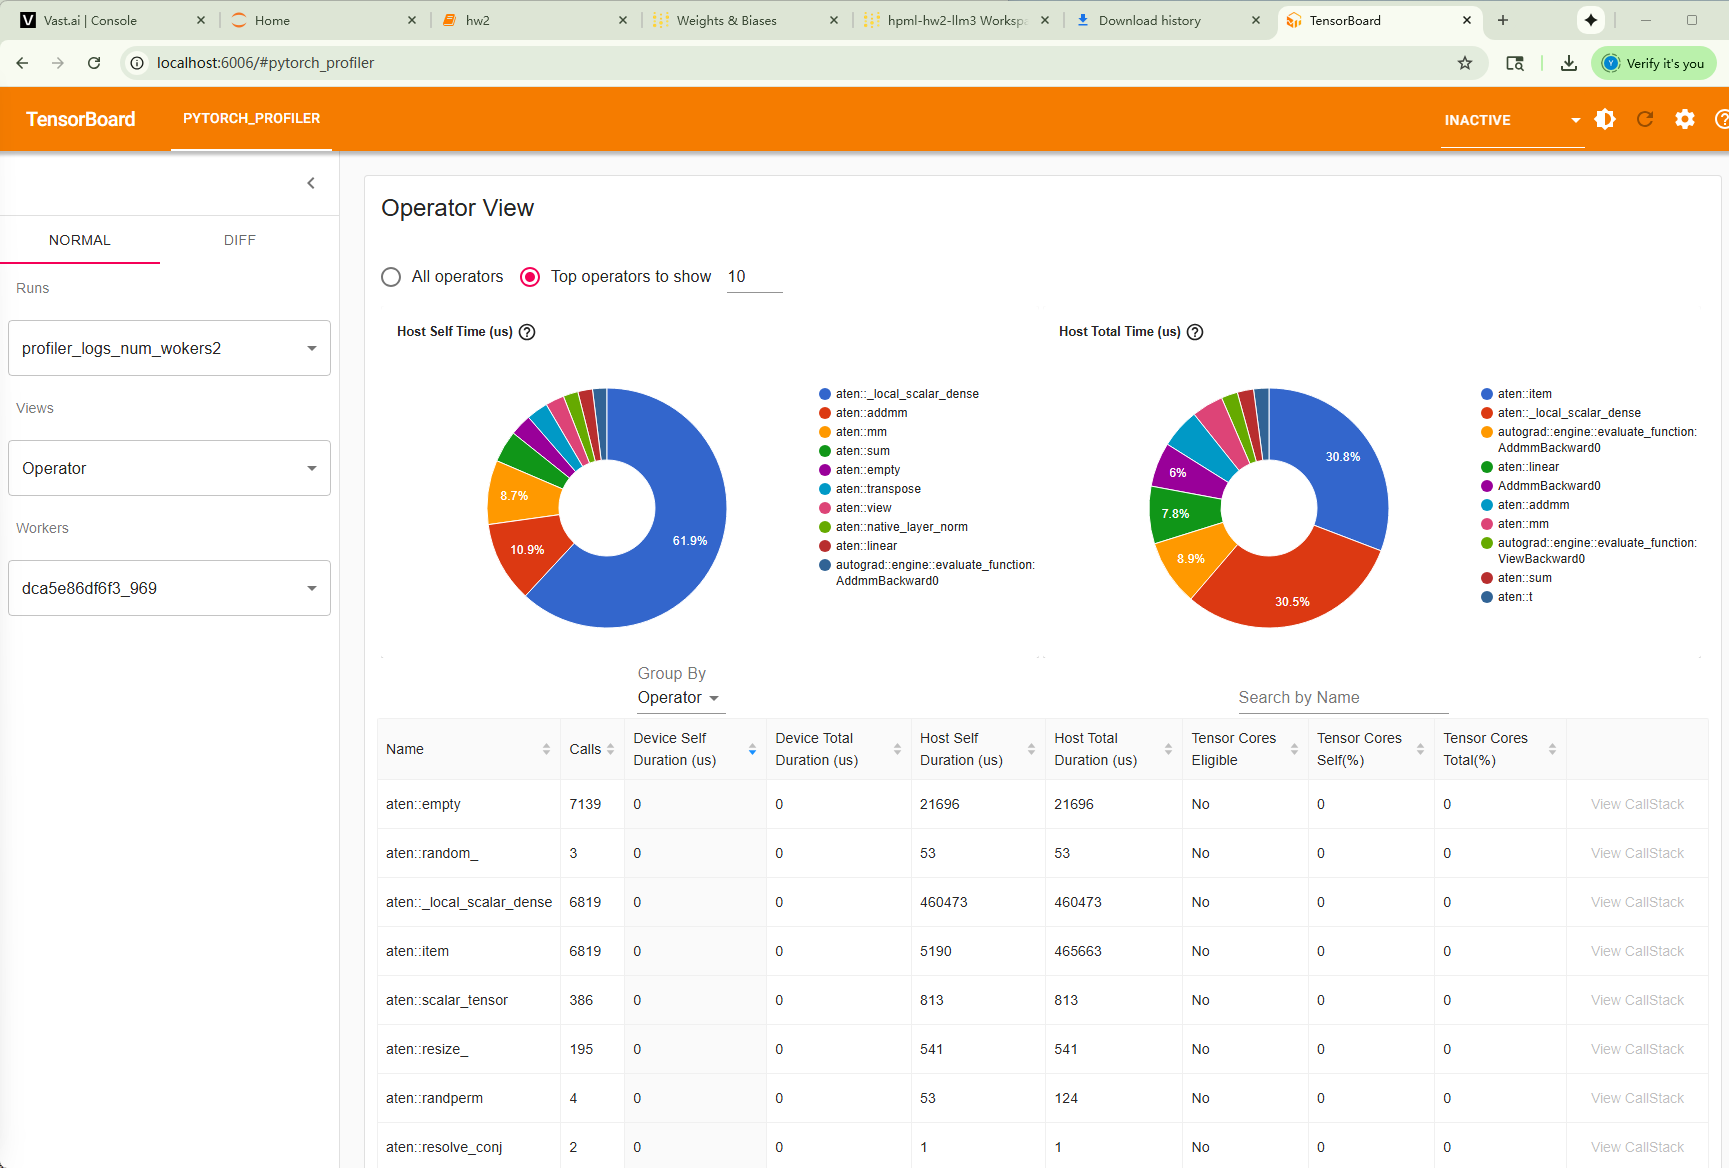 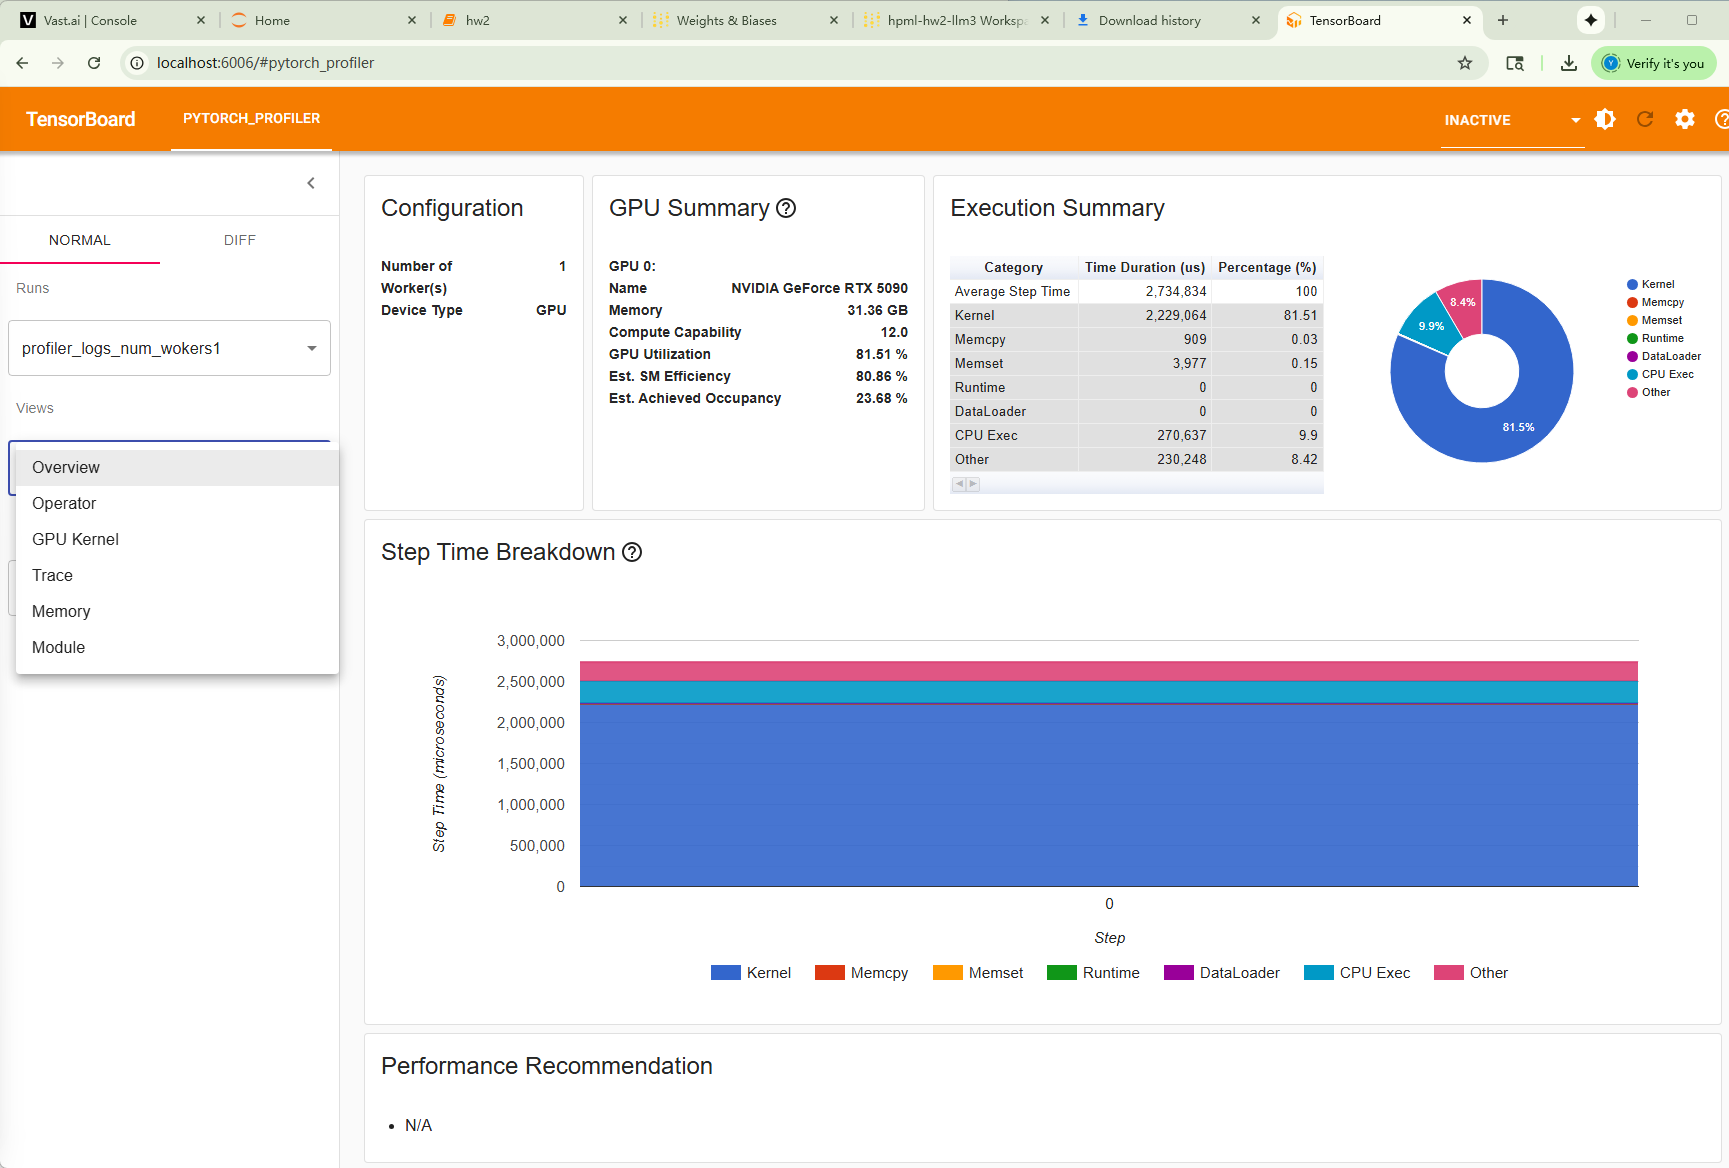 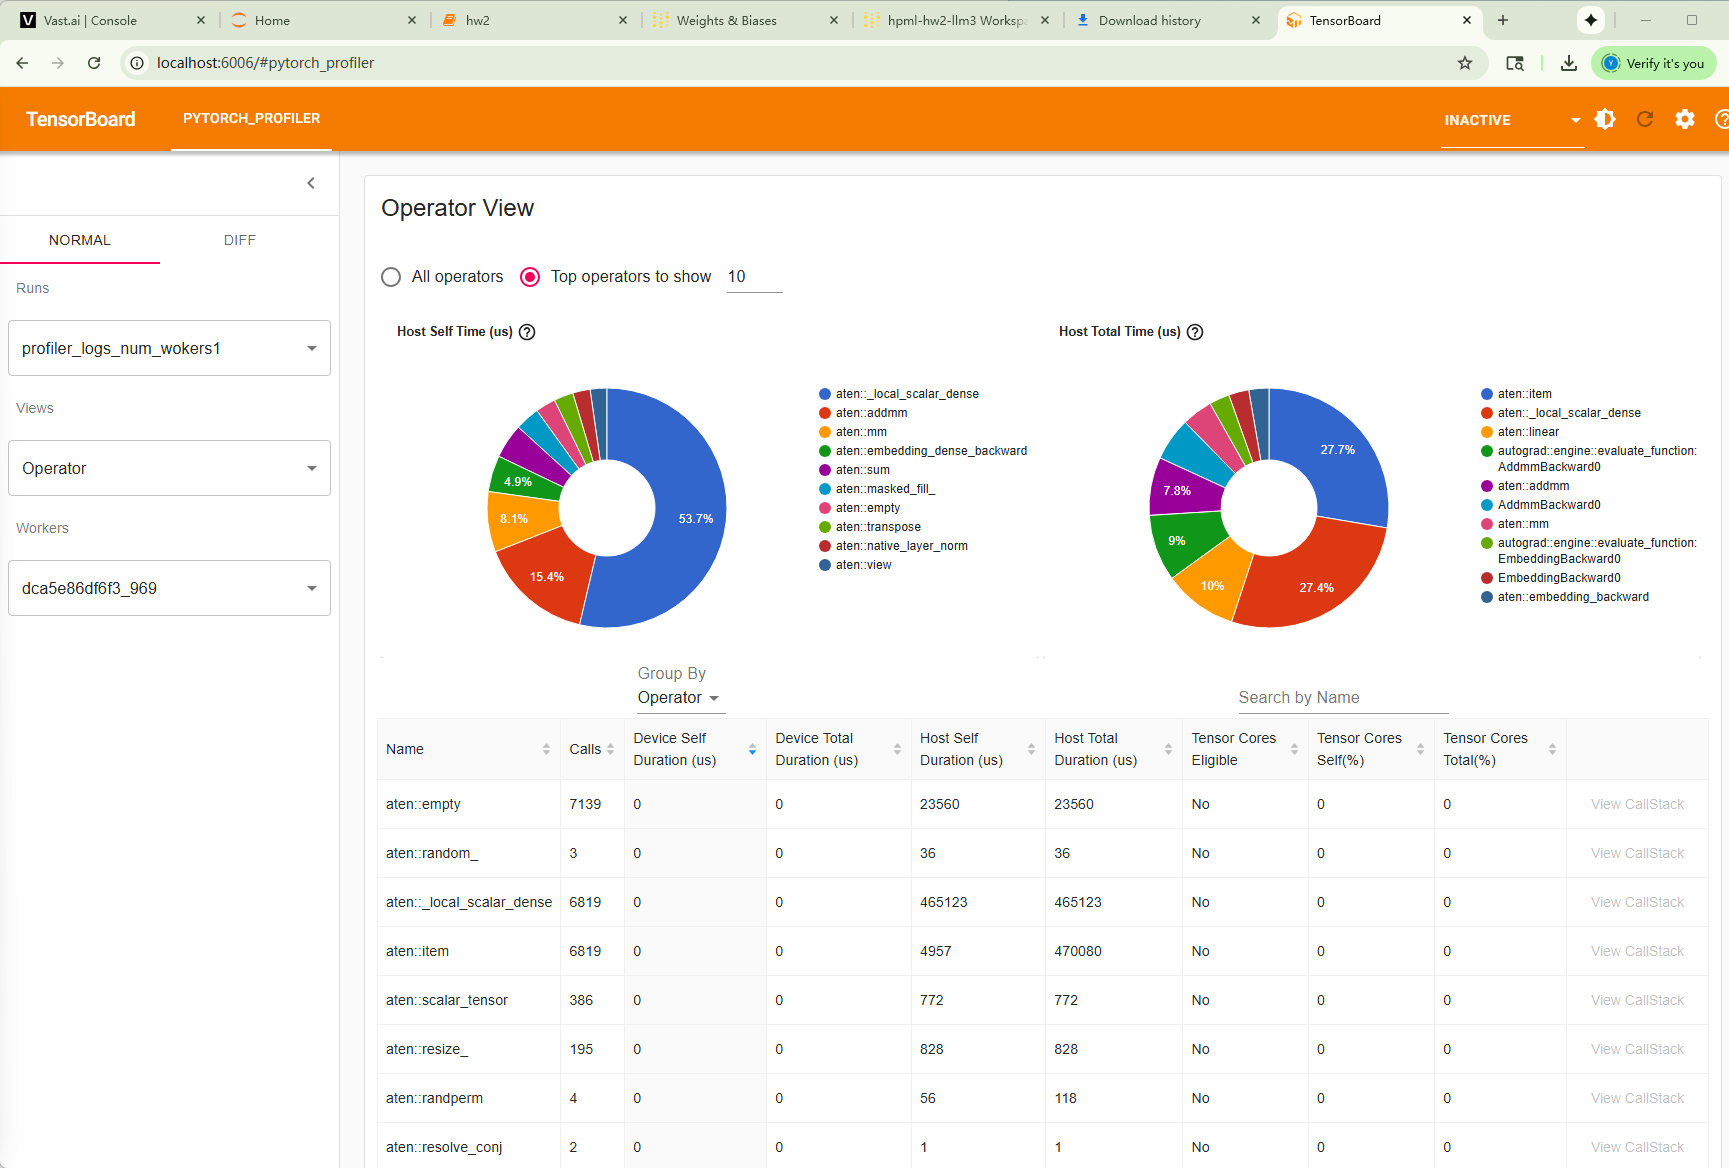 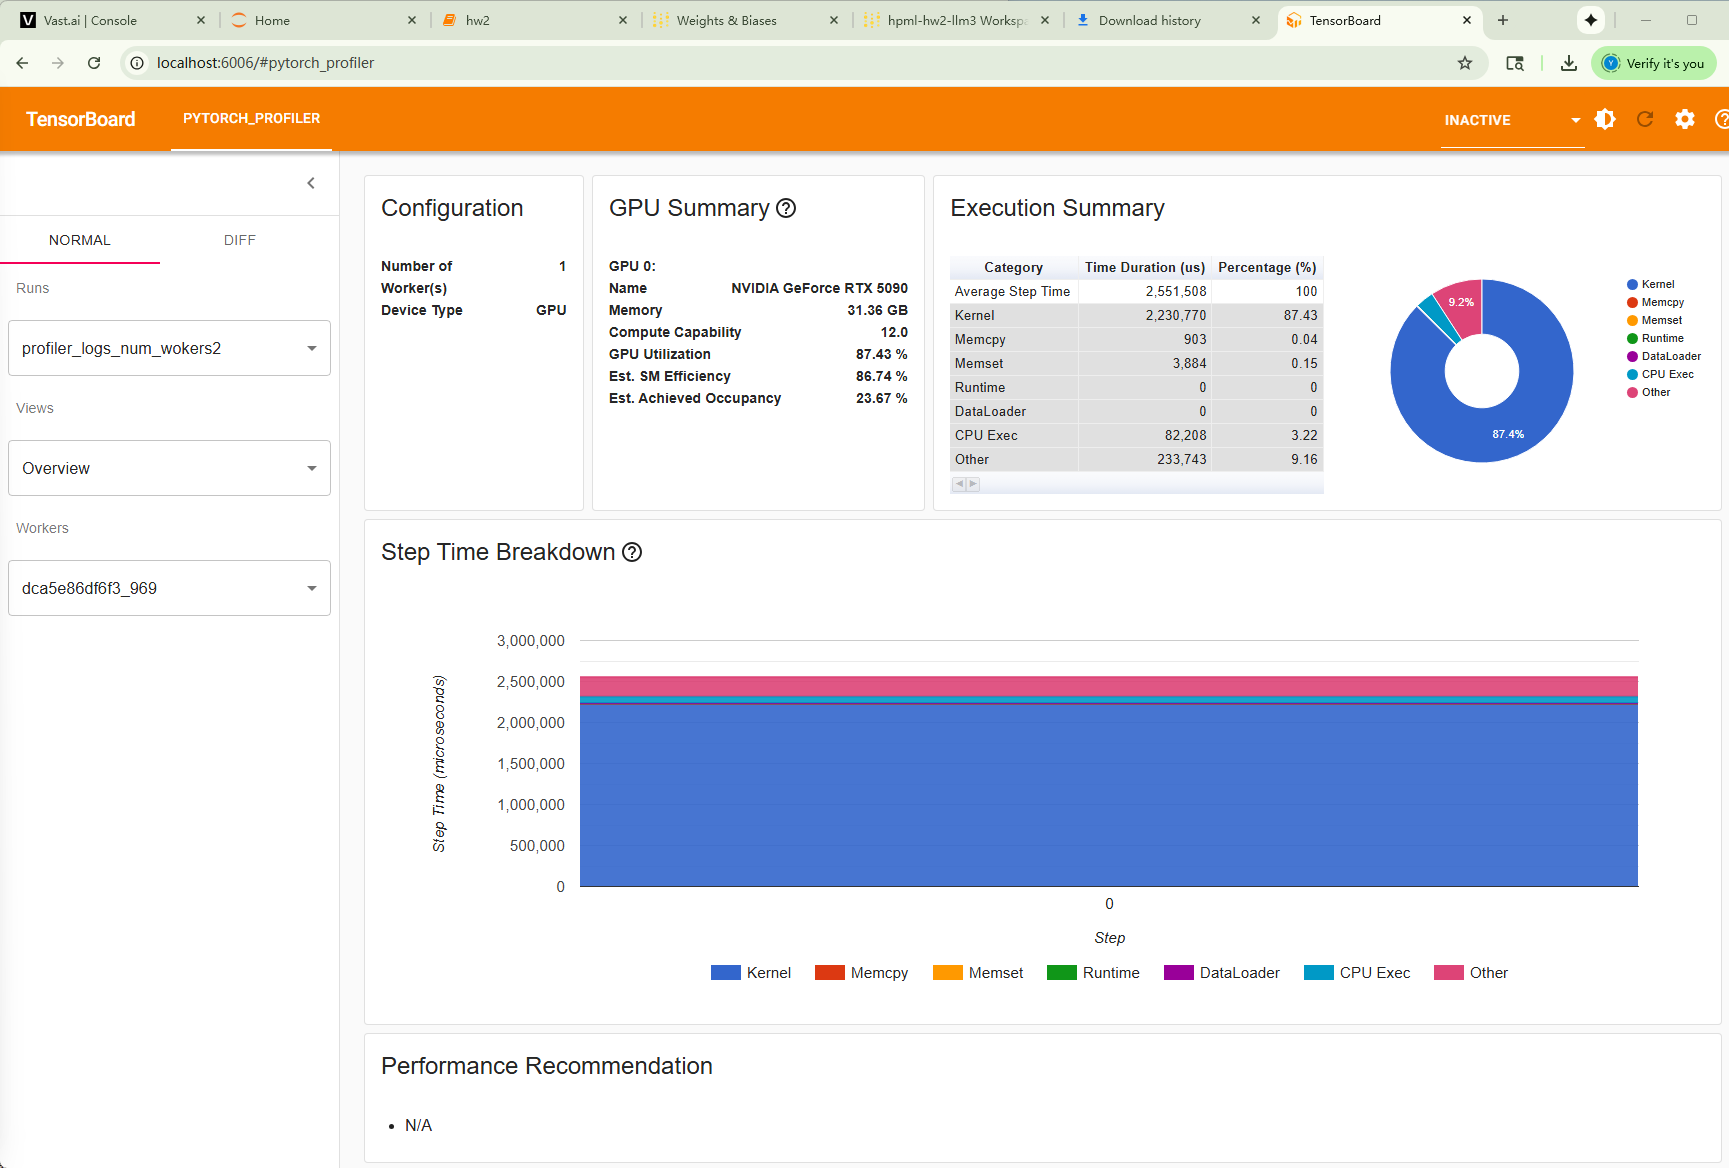

I found that print prof.key_average().table is extremely slow in jupyter notebook and jupyter collapsed for no reason from time to time. So I set the batch size to 1 and Significantly reduced the dataset size to get this result.

# C6


In [ ]:
avg_epoch_time = []
final_test_accuracy = []
avg_train_accuracy = []
final_train_loss = []
def train_C6():
  with wandb.init(
    group="Hyperparameter Sensitivity",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "optimizer": "AdamW", 
        "num_workers": 2,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
      config = wandb.config
      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_C6"
      
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
      sum_train_accuracy = 0
      avg_loss = 0
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        sum_train_accuracy += avg_accuracy
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append({"lr":config.learning_rate, "batch_size":config.batch_size, "avg_epoch_time":sum(epoch_time_arr)/len(epoch_time_arr)})
      avg_train_accuracy.append({"lr":config.learning_rate, "batch_size":config.batch_size, "avg_train_accuracy":sum_train_accuracy/config.epochs})
      final_train_loss.append({"lr":config.learning_rate, "batch_size":config.batch_size, "final_train_loss":avg_loss})

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)
    
      accuracy = correct / total
      final_test_accuracy.append({"lr":config.learning_rate, "batch_size":config.batch_size, "final_test_accuracy":accuracy})

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [5e-5, 1e-4, 5e-4]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C6, count=9)

Create sweep with ID: ol99ftwm
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/ol99ftwm


wandb: Agent Starting Run: p1bqe09h with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2918, Train Accuracy: 0.8799, Test Accuracy: 0.8775, data_loading time: 3.3743536472320557                 compute time: 48.26205515861511 total epoch time: 52.288145780563354
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1603, Train Accuracy: 0.9405, Test Accuracy: 0.9058, data_loading time: 3.3897156715393066                 compute time: 48.5977144241333 total epoch time: 52.78198218345642
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0862, Train Accuracy: 0.9705, Test Accuracy: 0.8950, data_loading time: 2.3981313705444336                 compute time: 47.99050521850586 total epoch time: 51.00476956367493
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0483, Train Accuracy: 0.9839, Test Accuracy: 0.8954, data_loading time: 3.0

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▅█▂▆▁
data-loading time,██▂▆▁
test/acc,▁█▅▅▃
total epoch time,▆█▂▆▁
train/acc,▁▅▇██
compute time,47.90713
data-loading time,2.29068
test/acc,0.88592
total epoch time,50.73609
train/acc,0.98768


wandb: Agent Starting Run: 4j2skc6g with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3212, Train Accuracy: 0.8652, Test Accuracy: 0.8912, data_loading time: 2.64289927482605                 compute time: 48.116403341293335 total epoch time: 51.40435862541199
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1931, Train Accuracy: 0.9298, Test Accuracy: 0.8748, data_loading time: 3.5315537452697754                 compute time: 48.540836811065674 total epoch time: 52.75370383262634
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.1134, Train Accuracy: 0.9611, Test Accuracy: 0.8567, data_loading time: 2.744121789932251                 compute time: 48.2916259765625 total epoch time: 51.64160513877869
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0717, Train Accuracy: 0.9768, Test Accuracy: 0.8475, data_loading time: 2.09

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▄█▅▁▄
data-loading time,▄█▄▁▄
test/acc,█▆▄▂▁
total epoch time,▄█▅▁▄
train/acc,▁▅▇██
compute time,48.15519
data-loading time,2.65506
test/acc,0.83656
total epoch time,51.45206
train/acc,0.98164


wandb: Agent Starting Run: u6bq0oxd with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.6979, Train Accuracy: 0.4982, Test Accuracy: 0.5000, data_loading time: 2.0696771144866943                 compute time: 47.677361249923706 total epoch time: 50.26917052268982
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.6939, Train Accuracy: 0.4967, Test Accuracy: 0.5000, data_loading time: 2.4066808223724365                 compute time: 48.00001931190491 total epoch time: 51.00696659088135
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.6938, Train Accuracy: 0.4936, Test Accuracy: 0.5000, data_loading time: 2.3085412979125977                 compute time: 47.86158561706543 total epoch time: 50.7403998374939
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6935, Train Accuracy: 0.4949, Test Accuracy: 0.5000, data_loading time: 2.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇▄█▂
data-loading time,▁▄▃█▂
test/acc,▁▁▁▁▁
total epoch time,▁▅▃█▂
train/acc,█▆▁▃▂
compute time,47.7543
data-loading time,2.22308
test/acc,0.5
total epoch time,50.47783
train/acc,0.49428


wandb: Agent Starting Run: x80pl9r7 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2823, Train Accuracy: 0.8813, Test Accuracy: 0.9020, data_loading time: 1.380310297012329                 compute time: 42.451884508132935 total epoch time: 44.200751543045044
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1539, Train Accuracy: 0.9419, Test Accuracy: 0.8943, data_loading time: 1.2978613376617432                 compute time: 42.62789964675903 total epoch time: 44.28197240829468
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0786, Train Accuracy: 0.9742, Test Accuracy: 0.9085, data_loading time: 1.2501893043518066                 compute time: 42.524516344070435 total epoch time: 44.11564493179321
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0447, Train Accuracy: 0.9847, Test Accuracy: 0.9077, data_loading time: 1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁█▄▃▄
data-loading time,█▅▃▂▁
test/acc,▅▁██▇
total epoch time,▆█▃▁▁
train/acc,▁▅▇██
compute time,42.52325
data-loading time,1.1968
test/acc,0.90592
total epoch time,44.06284
train/acc,0.99096


wandb: Agent Starting Run: wvw3j86f with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3062, Train Accuracy: 0.8685, Test Accuracy: 0.9012, data_loading time: 1.5294194221496582                 compute time: 42.4873571395874 total epoch time: 44.40516996383667
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1694, Train Accuracy: 0.9359, Test Accuracy: 0.8965, data_loading time: 1.2967138290405273                 compute time: 42.53153419494629 total epoch time: 44.18459892272949
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0856, Train Accuracy: 0.9698, Test Accuracy: 0.8786, data_loading time: 1.2219390869140625                 compute time: 42.48101878166199 total epoch time: 44.04977250099182
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0557, Train Accuracy: 0.9814, Test Accuracy: 0.8717, data_loading time: 1.7

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▂▃▂█▁
data-loading time,▅▂▁█▂
test/acc,█▇▄▃▁
total epoch time,▄▂▁█▁
train/acc,▁▅▇██
compute time,42.44294
data-loading time,1.2599
test/acc,0.86356
total epoch time,44.05166
train/acc,0.98552


wandb: Agent Starting Run: rafrijva with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.6957, Train Accuracy: 0.5024, Test Accuracy: 0.5000, data_loading time: 1.2267851829528809                 compute time: 42.107866525650024 total epoch time: 43.68450331687927
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.6940, Train Accuracy: 0.4998, Test Accuracy: 0.5000, data_loading time: 1.2665433883666992                 compute time: 42.39352369308472 total epoch time: 44.01552724838257
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.6936, Train Accuracy: 0.4962, Test Accuracy: 0.5000, data_loading time: 1.2540805339813232                 compute time: 42.26508092880249 total epoch time: 43.836198806762695
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6932, Train Accuracy: 0.4997, Test Accuracy: 0.5000, data_loading time: 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇▄█▄
data-loading time,▁▂▂█▂
test/acc,▁▁▁▁▁
total epoch time,▁▄▃█▃
train/acc,█▆▃▆▁
compute time,42.25425
data-loading time,1.28138
test/acc,0.5
total epoch time,43.88601
train/acc,0.4936


wandb: Agent Starting Run: e5syj5rl with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2871, Train Accuracy: 0.8793, Test Accuracy: 0.9125, data_loading time: 0.7448124885559082                 compute time: 40.29151630401611 total epoch time: 41.27488875389099
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1590, Train Accuracy: 0.9407, Test Accuracy: 0.9059, data_loading time: 0.7579576969146729                 compute time: 40.61621165275574 total epoch time: 41.60559034347534
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0764, Train Accuracy: 0.9744, Test Accuracy: 0.8921, data_loading time: 0.7468810081481934                 compute time: 40.65260195732117 total epoch time: 41.637370586395264
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0396, Train Accuracy: 0.9878, Test Accuracy: 0.8986, data_loading time: 0.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇██▇
data-loading time,▆█▇▁▇
test/acc,█▆▁▃▇
total epoch time,▁▇█▇█
train/acc,▁▅▇██
compute time,40.6347
data-loading time,0.75024
test/acc,0.90896
total epoch time,41.62162
train/acc,0.98864


wandb: Agent Starting Run: 733fjja3 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2942, Train Accuracy: 0.8734, Test Accuracy: 0.9015, data_loading time: 0.7395803928375244                 compute time: 40.36083436012268 total epoch time: 41.32348442077637
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1583, Train Accuracy: 0.9411, Test Accuracy: 0.9043, data_loading time: 0.7551038265228271                 compute time: 40.66460466384888 total epoch time: 41.65313982963562
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0768, Train Accuracy: 0.9735, Test Accuracy: 0.9009, data_loading time: 0.744041919708252                 compute time: 40.637380838394165 total epoch time: 41.61850595474243
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0468, Train Accuracy: 0.9836, Test Accuracy: 0.8866, data_loading time: 0.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁█▇██
data-loading time,▁█▃▂▂
test/acc,██▇▅▁
total epoch time,▁█▇▇▇
train/acc,▁▅▇██
compute time,40.64794
data-loading time,0.74093
test/acc,0.86296
total epoch time,41.62572
train/acc,0.98972


wandb: Agent Starting Run: xxz1nhu5 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.6968, Train Accuracy: 0.5070, Test Accuracy: 0.5000, data_loading time: 0.7187292575836182                 compute time: 40.23909902572632 total epoch time: 41.192381620407104
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.6941, Train Accuracy: 0.4930, Test Accuracy: 0.5000, data_loading time: 0.7286243438720703                 compute time: 40.48895764350891 total epoch time: 41.44946217536926
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.6933, Train Accuracy: 0.5028, Test Accuracy: 0.5000, data_loading time: 0.7374804019927979                 compute time: 40.398369550704956 total epoch time: 41.36970257759094
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6934, Train Accuracy: 0.5006, Test Accuracy: 0.5000, data_loading time: 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁█▅▄▃
data-loading time,▁▄▇▄█
test/acc,▁▁▁▁▁
total epoch time,▁█▆▄▃
train/acc,█▁▆▅▄
compute time,40.31126
data-loading time,0.73928
test/acc,0.5
total epoch time,41.27952
train/acc,0.49956


In [ ]:
def draw_heatmap(data, data_name):
    batch_sizes = [16, 32, 64]
    learning_rates = [5e-5, 1e-4, 5e-4]
    extracted_data = [[0] * 3 for _ in range(3)]
    for i in range(3):
        for j in range(3):
            extracted_data[i][j] = data[i * len(learning_rates) +  j][data_name]

    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(extracted_data, cmap="viridis", origin="lower")

    # Label axes
    ax.set_xticks(np.arange(len(learning_rates)))
    ax.set_yticks(np.arange(len(batch_sizes)))
    ax.set_xticklabels([f"{lr:.0e}" for lr in learning_rates])
    ax.set_yticklabels(batch_sizes)

    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Batch Size")
    ax.set_title(f"Figure F6: {data_name} (seconds)")

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f"{data_name} (s)")

    # Annotate values on heatmap
    for i in range(len(batch_sizes)):
        for j in range(len(learning_rates)):
            ax.text(j, i, f"{extracted_data[i][j]:.4f}",
                    ha="center", va="center", color="white", fontsize=9)

    plt.tight_layout()
    plt.show()


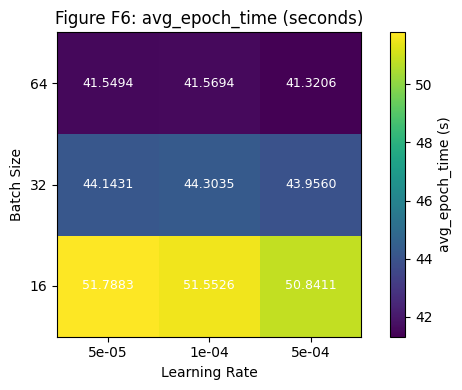

In [ ]:
draw_heatmap(avg_epoch_time, "avg_epoch_time")

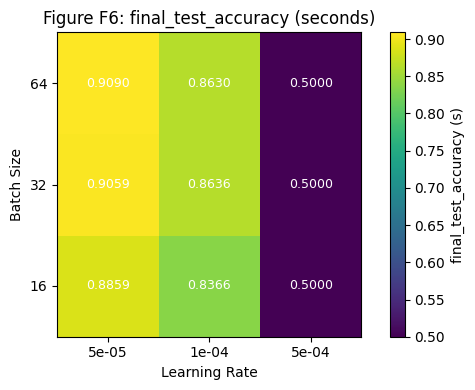

In [ ]:
draw_heatmap(final_test_accuracy, "final_test_accuracy")

In [ ]:
print(avg_epoch_time, final_train_loss, avg_train_accuracy, final_test_accuracy)

[{'lr': 5e-05, 'batch_size': 16, 'avg_epoch_time': 51.78834919929504}, {'lr': 0.0001, 'batch_size': 16, 'avg_epoch_time': 51.55258145332336}, {'lr': 0.0005, 'batch_size': 16, 'avg_epoch_time': 50.841063022613525}, {'lr': 5e-05, 'batch_size': 32, 'avg_epoch_time': 44.143100595474245}, {'lr': 0.0001, 'batch_size': 32, 'avg_epoch_time': 44.30346474647522}, {'lr': 0.0005, 'batch_size': 32, 'avg_epoch_time': 43.955963706970216}, {'lr': 5e-05, 'batch_size': 64, 'avg_epoch_time': 41.54936318397522}, {'lr': 0.0001, 'batch_size': 64, 'avg_epoch_time': 41.56937665939331}, {'lr': 0.0005, 'batch_size': 64, 'avg_epoch_time': 41.320552349090576}] [{'lr': 5e-05, 'batch_size': 16, 'final_train_loss': 0.03710960883797508}, {'lr': 0.0001, 'batch_size': 16, 'final_train_loss': 0.05841411100556003}, {'lr': 0.0005, 'batch_size': 16, 'final_train_loss': 0.6938722445960237}, {'lr': 5e-05, 'batch_size': 32, 'final_train_loss': 0.027467254890471964}, {'lr': 0.0001, 'batch_size': 32, 'final_train_loss': 0.04203

# Table T6
![Table T6.png](<attachment:Table T6.png>)
# Figure F6a
![Figure F6_a.png](<attachment:Figure F6_a.png>)
# Figure F6b
![Figure F6_b.png](<attachment:Figure F6_b.png>)

A high learning rate might improves convergence speed initially but it is easier to cause overshoot and makes model very unstable. 5e-4 learning rate get poor accuracy here. And a low learning rate tend to yeild more stable and accurate convergence at the cost of slow training.
A large batch size has higher GPU utilization and improves training speed, as we can see in F6(a). And it also increases gradient stability but might reduce generalization.
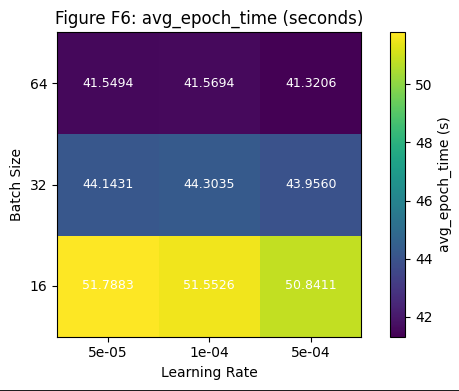
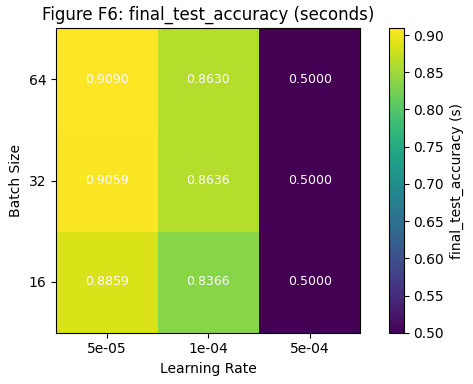
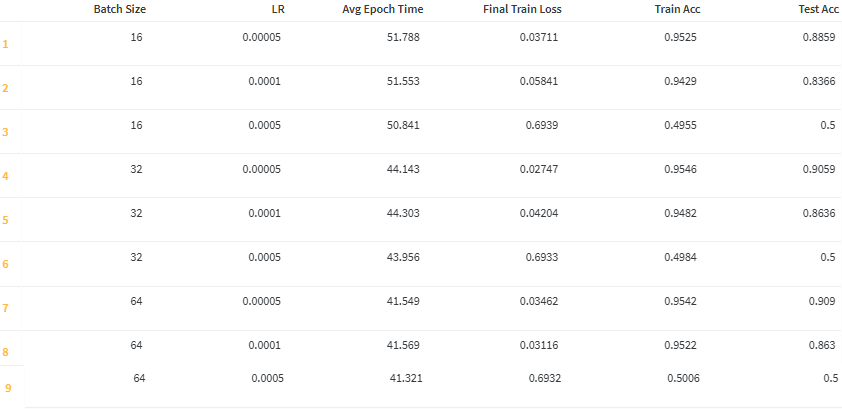

In [ ]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [ ]:
wandb.init(project=project_name, group="Hyperparameter Sensitivity", name="C6 result")

records = []
for i in range(len(avg_epoch_time)):
    records.append({
        "Batch Size": avg_epoch_time[i]["batch_size"],
        "LR": avg_epoch_time[i]["lr"],
        "Avg Epoch Time": avg_epoch_time[i]["avg_epoch_time"],
        "Final Train Loss": final_train_loss[i]["final_train_loss"],
        "Train Acc": avg_train_accuracy[i]["avg_train_accuracy"],
        "Test Acc": final_test_accuracy[i]["final_test_accuracy"]
    })

df = pd.DataFrame(records)
print(records)
wandb.log({"C6_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[{'Batch Size': 16, 'LR': 5e-05, 'Avg Epoch Time': 51.78834919929504, 'Final Train Loss': 0.03710960883797508, 'Train Acc': 0.9524800000000001, 'Test Acc': 0.88592}, {'Batch Size': 16, 'LR': 0.0001, 'Avg Epoch Time': 51.55258145332336, 'Final Train Loss': 0.05841411100556003, 'Train Acc': 0.942896, 'Test Acc': 0.83656}, {'Batch Size': 16, 'LR': 0.0005, 'Avg Epoch Time': 50.841063022613525, 'Final Train Loss': 0.6938722445960237, 'Train Acc': 0.49554400000000004, 'Test Acc': 0.5}, {'Batch Size': 32, 'LR': 5e-05, 'Avg Epoch Time': 44.143100595474245, 'Final Train Loss': 0.027467254890471964, 'Train Acc': 0.9546240000000001, 'Test Acc': 0.90592}, {'Batch Size': 32, 'LR': 0.0001, 'Avg Epoch Time': 44.30346474647522, 'Final Train Loss': 0.04203675107082443, 'Train Acc': 0.9482240000000001, 'Test Acc': 0.86356}, {'Batch Size': 32, 'LR': 0.0005, 'Avg Epoch Time': 43.955963706970216, 'Final Train Loss': 0.6932823576433275, 'Train Acc': 0.49835199999999996, 'Test Acc': 0.5}, {'Batch Size': 64, 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


# C7

In [ ]:
avg_epoch_time = []
final_test_accuracy = []
avg_train_accuracy = []
final_train_loss = []
def train_C7():
  with wandb.init(
    group="Optimizer Comparison",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "num_workers": 2,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
      config = wandb.config

      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_optimizer{wandb.config.optimizer}_C7"
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)

      sum_train_accuracy = 0
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
      avg_loss = 0
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        sum_train_accuracy += avg_accuracy
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append(sum(epoch_time_arr)/len(epoch_time_arr))
      avg_train_accuracy.append(sum_train_accuracy/config.epochs)
      final_train_loss.append(avg_loss)

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)

      accuracy = correct / total
      final_test_accuracy.append(accuracy)
      

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        "optimizer":{'values': ["SGD", "Adam", "AdamW"]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C7, count=3)
wandb.finish()

Create sweep with ID: ag698rmo
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/ag698rmo


wandb: Agent Starting Run: uz3ic7vh with config:
wandb: 	optimizer: SGD
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(SGD)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.6901, Train Accuracy: 0.5355, Test Accuracy: 0.6423, data_loading time: 1.5294487476348877                 compute time: 39.746360063552856 total epoch time: 41.6770966053009
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.6870, Train Accuracy: 0.5646, Test Accuracy: 0.7062, data_loading time: 1.3255527019500732                 compute time: 40.08788824081421 total epoch time: 41.7652153968811
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.6831, Train Accuracy: 0.5985, Test Accuracy: 0.7379, data_loading time: 1.2157022953033447                 compute time: 40.16151428222656 total epoch time: 41.72612023353577
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.6774, Train Accuracy: 0.6454, Test Accuracy: 0.7638, data_loading time: 1.661303997039795                 compute time: 40.28585433959961 total epoch time: 42.32447147369385
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.6688, Train Accuracy: 0.6917, Test Accuracy: 0.7910, data_loading time: 1.195335865020752                 compute time: 40.24841237068176 total epoch time: 41.75717902183533
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▅▆██
data-loading time,▆▃▁█▁
test/acc,▁▄▅▇█
total epoch time,▁▂▂█▂
train/acc,▁▂▄▆█
compute time,40.24841
data-loading time,1.19534
test/acc,0.79104
total epoch time,41.75718
train/acc,0.69172


wandb: Agent Starting Run: owfjtgk8 with config:
wandb: 	optimizer: Adam
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(Adam)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.3091, Train Accuracy: 0.8702, Test Accuracy: 0.8963, data_loading time: 1.1931238174438477                 compute time: 41.82681155204773 total epoch time: 43.36403226852417
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1737, Train Accuracy: 0.9376, Test Accuracy: 0.8934, data_loading time: 1.3262810707092285                 compute time: 42.13050699234009 total epoch time: 43.81422972679138
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0948, Train Accuracy: 0.9681, Test Accuracy: 0.8849, data_loading time: 1.2684111595153809                 compute time: 42.10042643547058 total epoch time: 43.69369578361511
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0556, Train Accuracy: 0.9819, Test Accuracy: 0.8732, data_loading time: 1.413574457168579                 compute time: 42.19941258430481 total epoch time: 43.985220193862915
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0428, Train Accuracy: 0.9866, Test Accuracy: 0.8752, data_loading time: 1.2387244701385498                 compute time: 42.083521127700806 total epoch time: 43.66766166687012
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇▆█▆
data-loading time,▁▅▃█▂
test/acc,█▇▅▁▂
total epoch time,▁▆▅█▄
train/acc,▁▅▇██
compute time,42.08352
data-loading time,1.23872
test/acc,0.8752
total epoch time,43.66766
train/acc,0.98656


wandb: Agent Starting Run: 0tg2qs0g with config:
wandb: 	optimizer: AdamW
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.3277, Train Accuracy: 0.8561, Test Accuracy: 0.8962, data_loading time: 1.2141618728637695                 compute time: 42.11078214645386 total epoch time: 43.668431997299194
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1756, Train Accuracy: 0.9337, Test Accuracy: 0.8796, data_loading time: 1.4400174617767334                 compute time: 42.49151945114136 total epoch time: 44.29966640472412
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0942, Train Accuracy: 0.9682, Test Accuracy: 0.8770, data_loading time: 1.3452110290527344                 compute time: 42.47234344482422 total epoch time: 44.17823624610901
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0619, Train Accuracy: 0.9798, Test Accuracy: 0.8719, data_loading time: 1.2391769886016846                 compute time: 42.401289224624634 total epoch time: 43.9822461605072
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0397, Train Accuracy: 0.9870, Test Accuracy: 0.8628, data_loading time: 1.3745265007019043                 compute time: 42.46309995651245 total epoch time: 44.2026469707489
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁██▆▇
data-loading time,▁█▅▂▆
test/acc,█▅▄▃▁
total epoch time,▁█▇▄▇
train/acc,▁▅▇██
compute time,42.4631
data-loading time,1.37453
test/acc,0.86284
total epoch time,44.20265
train/acc,0.987


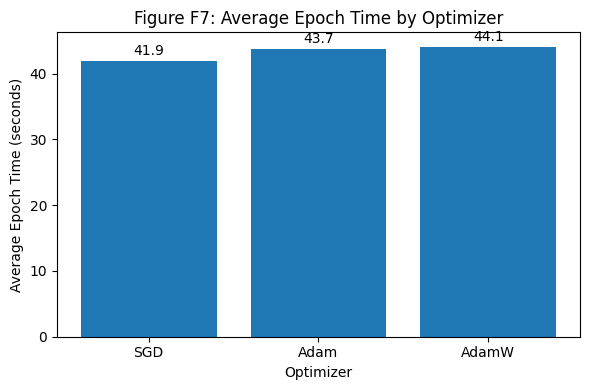

In [ ]:
optimizers = ["SGD", "Adam", "AdamW"]

# Create figure
plt.figure(figsize=(6, 4))
bars = plt.bar(optimizers, avg_epoch_time)

# Add labels and title
plt.xlabel("Optimizer")
plt.ylabel("Average Epoch Time (seconds)")
plt.title("Figure F7: Average Epoch Time by Optimizer")

# Annotate values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
             f"{height:.1f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
print(avg_epoch_time, final_train_loss, avg_train_accuracy, final_test_accuracy)

[41.85001654624939, 43.70496792793274, 44.066245555877686] [0.6688132436226701, 0.0427789768023813, 0.03970071057877009] [0.60712, 0.9488480000000001, 0.9449759999999999] [0.79104, 0.8752, 0.86284]


# Table T7
![Table T7.png](<attachment:Table T7.png>)
# Figure F7
![Figure F7.png](<attachment:Figure F7.png>)


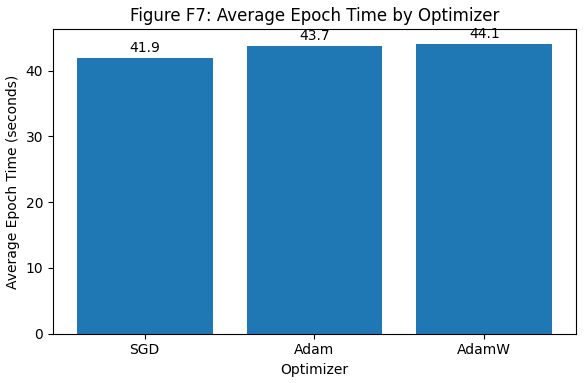
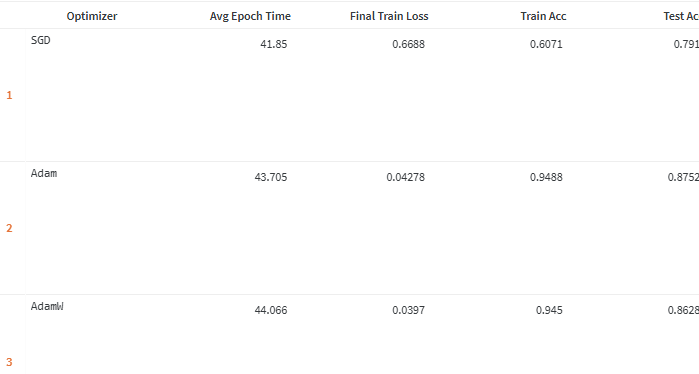

SGD converges much slowlier than Adam and AdamW and has 15x train loss than others. And we can't see much difference with Adam and AdamW here. Typically, Adam converges rapidly but with higher variance and AdamW offers a balance between speed and stability.

In [ ]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [ ]:
wandb.init(project=project_name, group="Optimizer Comparison", name="C7_result")
records = []
optimizers = ["SGD", "Adam", "AdamW"]
for i in range(len(optimizers)):
    records.append({
        "Optimizer": optimizers[i],
        "Avg Epoch Time": avg_epoch_time[i],
        "Final Train Loss": final_train_loss[i],
        "Train Acc": avg_train_accuracy[i],
        "Test Acc": final_test_accuracy[i]
    })

df = pd.DataFrame(records)
wandb.log({"C7_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


# C8

In [ ]:

final_test_accuracy = []
avg_train_accuracy = []
final_train_loss = []
first_epoch_time = []
avg_afterwards_epoch_time = []
def train_C8():
  with wandb.init(
    group="Eagar vs. Compile",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "optimizer": "AdamW",
        "num_workers": 2,
        "epochs": 10, 
    }) as run:
      config = wandb.config

      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_compile{config.compile_mode}_C8"
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      if (config.compile_mode == True):
        model = torch.compile(model, backend="inductor")
      model.to(device)
      print(type(model))

      sum_train_accuracy = 0
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
      avg_loss = 0
      sum_epoch_time = 0
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        sum_train_accuracy += avg_accuracy
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        
        if epoch == 0:
            first_epoch_time.append(total_epoch_time)
        if epoch >= 5:
            sum_epoch_time += total_epoch_time
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append(sum(epoch_time_arr)/len(epoch_time_arr))
      avg_train_accuracy.append(sum_train_accuracy/config.epochs)
      final_train_loss.append(avg_loss)
      avg_afterwards_epoch_time.append(sum_epoch_time / 5)

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)
    
      accuracy = correct / total
      final_test_accuracy.append(accuracy)
      

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        "compile_mode":{'values': [True, False]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C8, count=2)
wandb.finish()


Create sweep with ID: vnlmen3k
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/vnlmen3k


wandb: Agent Starting Run: sv3pboqa with config:
wandb: 	compile_mode: True
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'torch._dynamo.eval_frame.OptimizedModule'>
---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/10, Loss: 0.3247, Train Accuracy: 0.8597, Test Accuracy: 0.8744, data_loading time: 1.418013572692871                 compute time: 39.92075705528259 total epoch time: 41.62350416183472
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/10, Loss: 0.1737, Train Accuracy: 0.9368, Test Accuracy: 0.8906, data_loading time: 1.3532395362854004                 compute time: 40.57009410858154 total epoch time: 42.201220989227295
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/10, Loss: 0.0839, Train Accuracy: 0.9709, Test Accuracy: 0.8723, data_loading time: 1.2285313606262207                 compute time: 40.77458333969116 total epoch time: 42.26802182197571
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/10, Loss: 0.0574, Train Accuracy: 0.9813, Test Accuracy: 0.8733, data_loading time: 1.4076130390167236                 compute time: 40.84573483467102 total epoch time: 42.535831689834595
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/10, Loss: 0.0402, Train Accuracy: 0.9872, Test Accuracy: 0.8639, data_loading time: 1.2851331233978271                 compute time: 40.803165912628174 total epoch time: 42.35278344154358
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 6/10, Loss: 0.0333, Train Accuracy: 0.9900, Test Accuracy: 0.8663, data_loading time: 1.2399680614471436                 compute time: 40.78580164909363 total epoch time: 42.29357385635376
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 7/10, Loss: 0.0282, Train Accuracy: 0.9916, Test Accuracy: 0.8474, data_loading time: 1.2487611770629883                 compute time: 40.74176549911499 total epoch time: 42.25001811981201
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 8/10, Loss: 0.0314, Train Accuracy: 0.9901, Test Accuracy: 0.8421, data_loading time: 1.2696943283081055                 compute time: 40.7682466506958 total epoch time: 42.306559562683105
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 9/10, Loss: 0.0235, Train Accuracy: 0.9931, Test Accuracy: 0.8475, data_loading time: 1.4323551654815674                 compute time: 40.78888440132141 total epoch time: 42.504047870635986
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 10/10, Loss: 0.0248, Train Accuracy: 0.9932, Test Accuracy: 0.8440, data_loading time: 1.2908835411071777                 compute time: 40.68842148780823 total epoch time: 42.23023557662964
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▆▇███▇▇█▇
data-loading time,█▅▁▇▃▁▂▂█▃
test/acc,▆█▅▅▄▄▂▁▂▁
total epoch time,▁▅▆█▇▆▆▆█▆
train/acc,▁▅▇▇██████
compute time,40.68842
data-loading time,1.29088
test/acc,0.84404
total epoch time,42.23024
train/acc,0.99316


wandb: Agent Starting Run: 279apgn7 with config:
wandb: 	compile_mode: False
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/10, Loss: 0.2992, Train Accuracy: 0.8761, Test Accuracy: 0.8953, data_loading time: 1.238447666168213                 compute time: 42.158151149749756 total epoch time: 43.7539918422699
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/10, Loss: 0.1709, Train Accuracy: 0.9364, Test Accuracy: 0.8832, data_loading time: 1.3002090454101562                 compute time: 42.42946457862854 total epoch time: 44.071531534194946
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/10, Loss: 0.0895, Train Accuracy: 0.9689, Test Accuracy: 0.8903, data_loading time: 1.3439393043518066                 compute time: 42.43321990966797 total epoch time: 44.14191269874573
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/10, Loss: 0.0549, Train Accuracy: 0.9814, Test Accuracy: 0.8730, data_loading time: 1.3206939697265625                 compute time: 42.394832372665405 total epoch time: 44.070712089538574
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/10, Loss: 0.0367, Train Accuracy: 0.9873, Test Accuracy: 0.8738, data_loading time: 1.6793389320373535                 compute time: 42.599968671798706 total epoch time: 44.69762635231018
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 6/10, Loss: 0.0345, Train Accuracy: 0.9886, Test Accuracy: 0.8768, data_loading time: 1.434535026550293                 compute time: 42.40711259841919 total epoch time: 44.21923112869263
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 7/10, Loss: 0.0279, Train Accuracy: 0.9905, Test Accuracy: 0.8475, data_loading time: 1.2670419216156006                 compute time: 42.32213115692139 total epoch time: 43.94996213912964
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 8/10, Loss: 0.0249, Train Accuracy: 0.9910, Test Accuracy: 0.8602, data_loading time: 1.3984229564666748                 compute time: 42.26859664916992 total epoch time: 44.03139567375183
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 9/10, Loss: 0.0235, Train Accuracy: 0.9925, Test Accuracy: 0.8422, data_loading time: 1.555617332458496                 compute time: 42.46973276138306 total epoch time: 44.43778443336487
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 10/10, Loss: 0.0201, Train Accuracy: 0.9942, Test Accuracy: 0.8427, data_loading time: 1.699692726135254                 compute time: 42.58069634437561 total epoch time: 44.717750787734985
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▅▅▅█▅▄▃▆█
data-loading time,▁▂▃▂█▄▁▃▆█
test/acc,█▆▇▅▅▆▂▃▁▁
total epoch time,▁▃▄▃█▄▂▃▆█
train/acc,▁▅▇▇██████
compute time,42.5807
data-loading time,1.69969
test/acc,0.84268
total epoch time,44.71775
train/acc,0.99416


[41.62350416183472, 43.7539918422699]


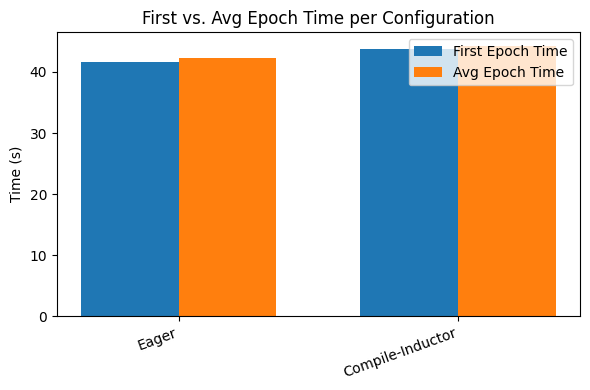

In [ ]:
labels = ["Compile-Inductor", "Eager"]

x = np.arange(len(labels))
bar_width = 0.35

print(first_epoch_time)
# Plot
plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, first_epoch_time, width=bar_width, label="First Epoch Time")
plt.bar(x + bar_width/2, avg_afterwards_epoch_time, width=bar_width, label="Avg Epoch Time")

# Formatting
plt.xticks(x, labels, rotation=20, ha='right')
plt.ylabel("Time (s)")
plt.title("First vs. Avg Epoch Time per Configuration")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(first_epoch_time, avg_afterwards_epoch_time)

[41.62350416183472, 43.7539918422699] [42.3168869972229, 44.27122483253479]


# Figure F8
![Figure T8.png](<attachment:Figure T8.png>)
# Table T8
![Table T8.png](<attachment:Table T8.png>)
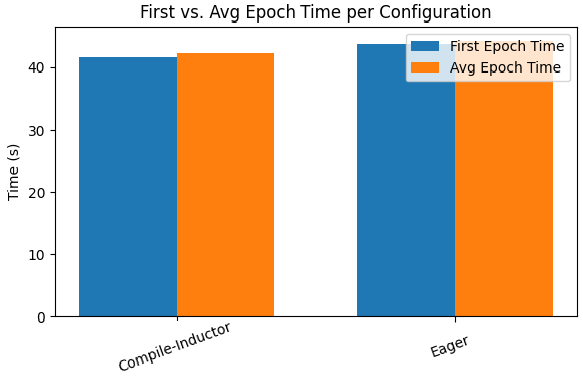
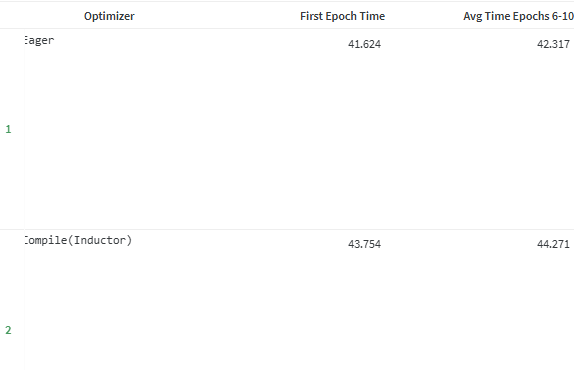

I mixed up the print order at first so the figure should be Compile-Inductor on the left and Eager on the right. And the order in table should be swapped too.
I don't know why compile mode is faster than eager all the time. Maybe there are some cache since I run this file thousands of times. Typically, the first compiled epoch is slower because compile mode need extra time to capture compute graph. And later epochs are faster because compile mode performs many optimizations with the compute graph.

In [ ]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


KeyboardInterrupt: 

In [ ]:
wandb.init(project=project_name, name="C8 result", group="Eager vs. Compile")

records = []
mode = ["Compile(Inductor)", "Eager"]
for i in range(len(mode)):
    records.append({
        "Optimizer": mode[i],
        "First Epoch Time": first_epoch_time[i],
        "Avg Time Epochs 6-10": avg_afterwards_epoch_time[i]
    })

df = pd.DataFrame(records)
wandb.log({"C8_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [15]:
model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

optimizer = AdamW(model.parameters(), lr=1e-4)

embedding = model.distilbert.embeddings
vocab_size, hidden_dim = embedding.word_embeddings.weight.shape
print(f"Q1 {embedding.word_embeddings} Vocab size: {vocab_size}, Hidden size: {hidden_dim}")

batch_size, seq_len = 4, 100
num_labels = 2
input_ids = torch.randint(0, model.config.vocab_size, (batch_size, seq_len))
attention_mask = torch.ones_like(input_ids)
labels = torch.randint(0, num_labels, (batch_size,))  # random ground-truth labels
outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
print(outputs)

print(f"Q2 {logits.shape}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params:,}")

loss = outputs.loss
loss.backward()
params_with_grad = sum(p.numel() for p in model.parameters() if p.grad is not None)
print(f"Parameters with gradients after backward: {params_with_grad:,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q1 Embedding(30522, 768, padding_idx=0) Vocab size: 30522, Hidden size: 768
SequenceClassifierOutput(loss=tensor(0.7038, grad_fn=<NllLossBackward0>), logits=tensor([[-0.0863,  0.0127],
        [-0.1413,  0.0226],
        [-0.1154,  0.0150],
        [-0.1094,  0.0183]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
Q2 torch.Size([4, 2])
Total trainable parameters: 66,955,010
Parameters with gradients after backward: 66,955,010


### Q1 
30522
### Q2
batch_size x 2
### Q3
66,955,010. 66,955,010
### Q4
The model parameters don't change but optimizers adds extra internal states. Suppose trainable parameter is N, Adam has 2N extra state with 1st and 2nd moments for every parameter.
### Q5
The first compiled epoch is slower because compile mode need extra time to capture compute graph. And later epochs are faster because compile mode performs many optimizations with the compute graph, such as operator fusion, memory planning, dead code elimination, etc.